In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

%matplotlib inline
%config InlineBackend.figure_format = "retina"


register_matplotlib_converters()
sns.set(style = "whitegrid", palette = "muted", font_scale = 1.5)

rcParams["figure.figsize"] = 22, 10

In [3]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [4]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("/content/drive/MyDrive/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["z_axis"] = df["z_axis"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

<ipython-input-4-56736d26e660>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


(1098204, 6)


In [5]:
mapping = {'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

user_id activity        timestamp    x_axis     y_axis    z_axis  \
0             33  Jogging   49105962326000 -0.694638  12.680544  0.503953   
1             33  Jogging   49106062271000  5.012288  11.264028  0.953424   
2             33  Jogging   49106112167000  4.903325  10.882658 -0.081722   
3             33  Jogging   49106222305000 -0.612916  18.496431  3.023717   
4             33  Jogging   49106332290000 -1.184970  12.108489  7.205164   
...          ...      ...              ...       ...        ...       ...   
1098200       19  Sitting  131623331483000  9.000000  -1.570000  1.690000   
1098201       19  Sitting  131623371431000  9.040000  -1.460000  1.730000   
1098202       19  Sitting  131623411592000  9.080000  -1.380000  1.690000   
1098203       19  Sitting  131623491487000  9.000000  -1.460000  1.730000   
1098204       19  Sitting  131623531465000  8.880000  -1.330000  1.610000   

         ActivityEncoded  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
...                  ...  
1098200                4  
1098201                4  
1098202                4  
1098203                4  
1098204                4  

[1098204 rows x 7 columns]

<Axes: xlabel='activity', ylabel='count'>

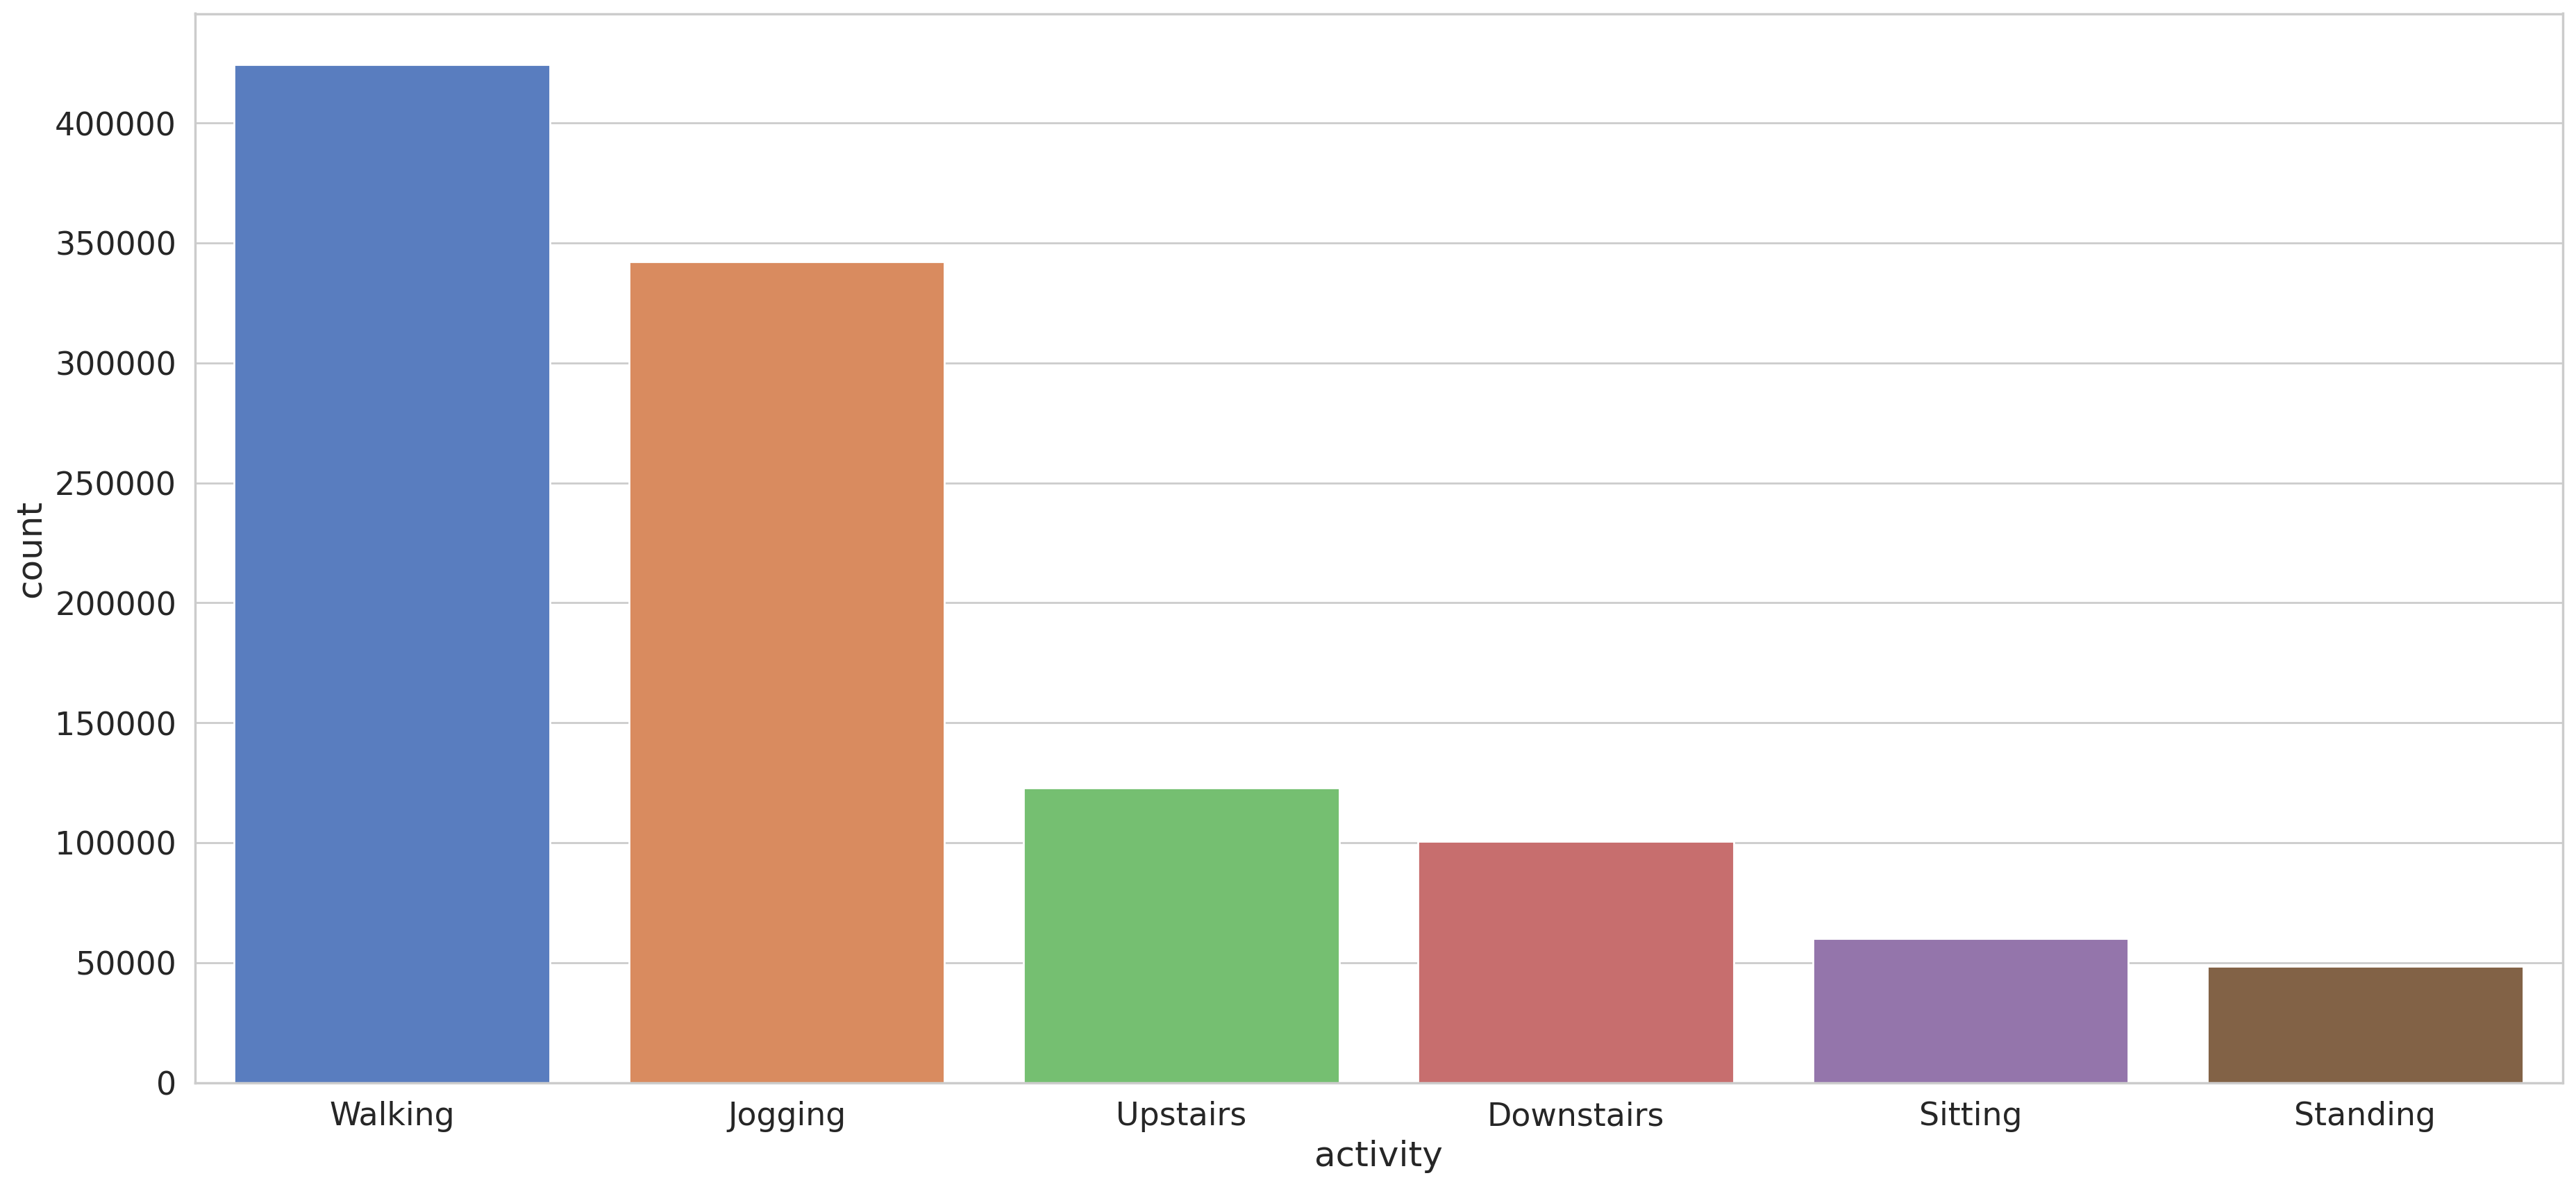

In [6]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

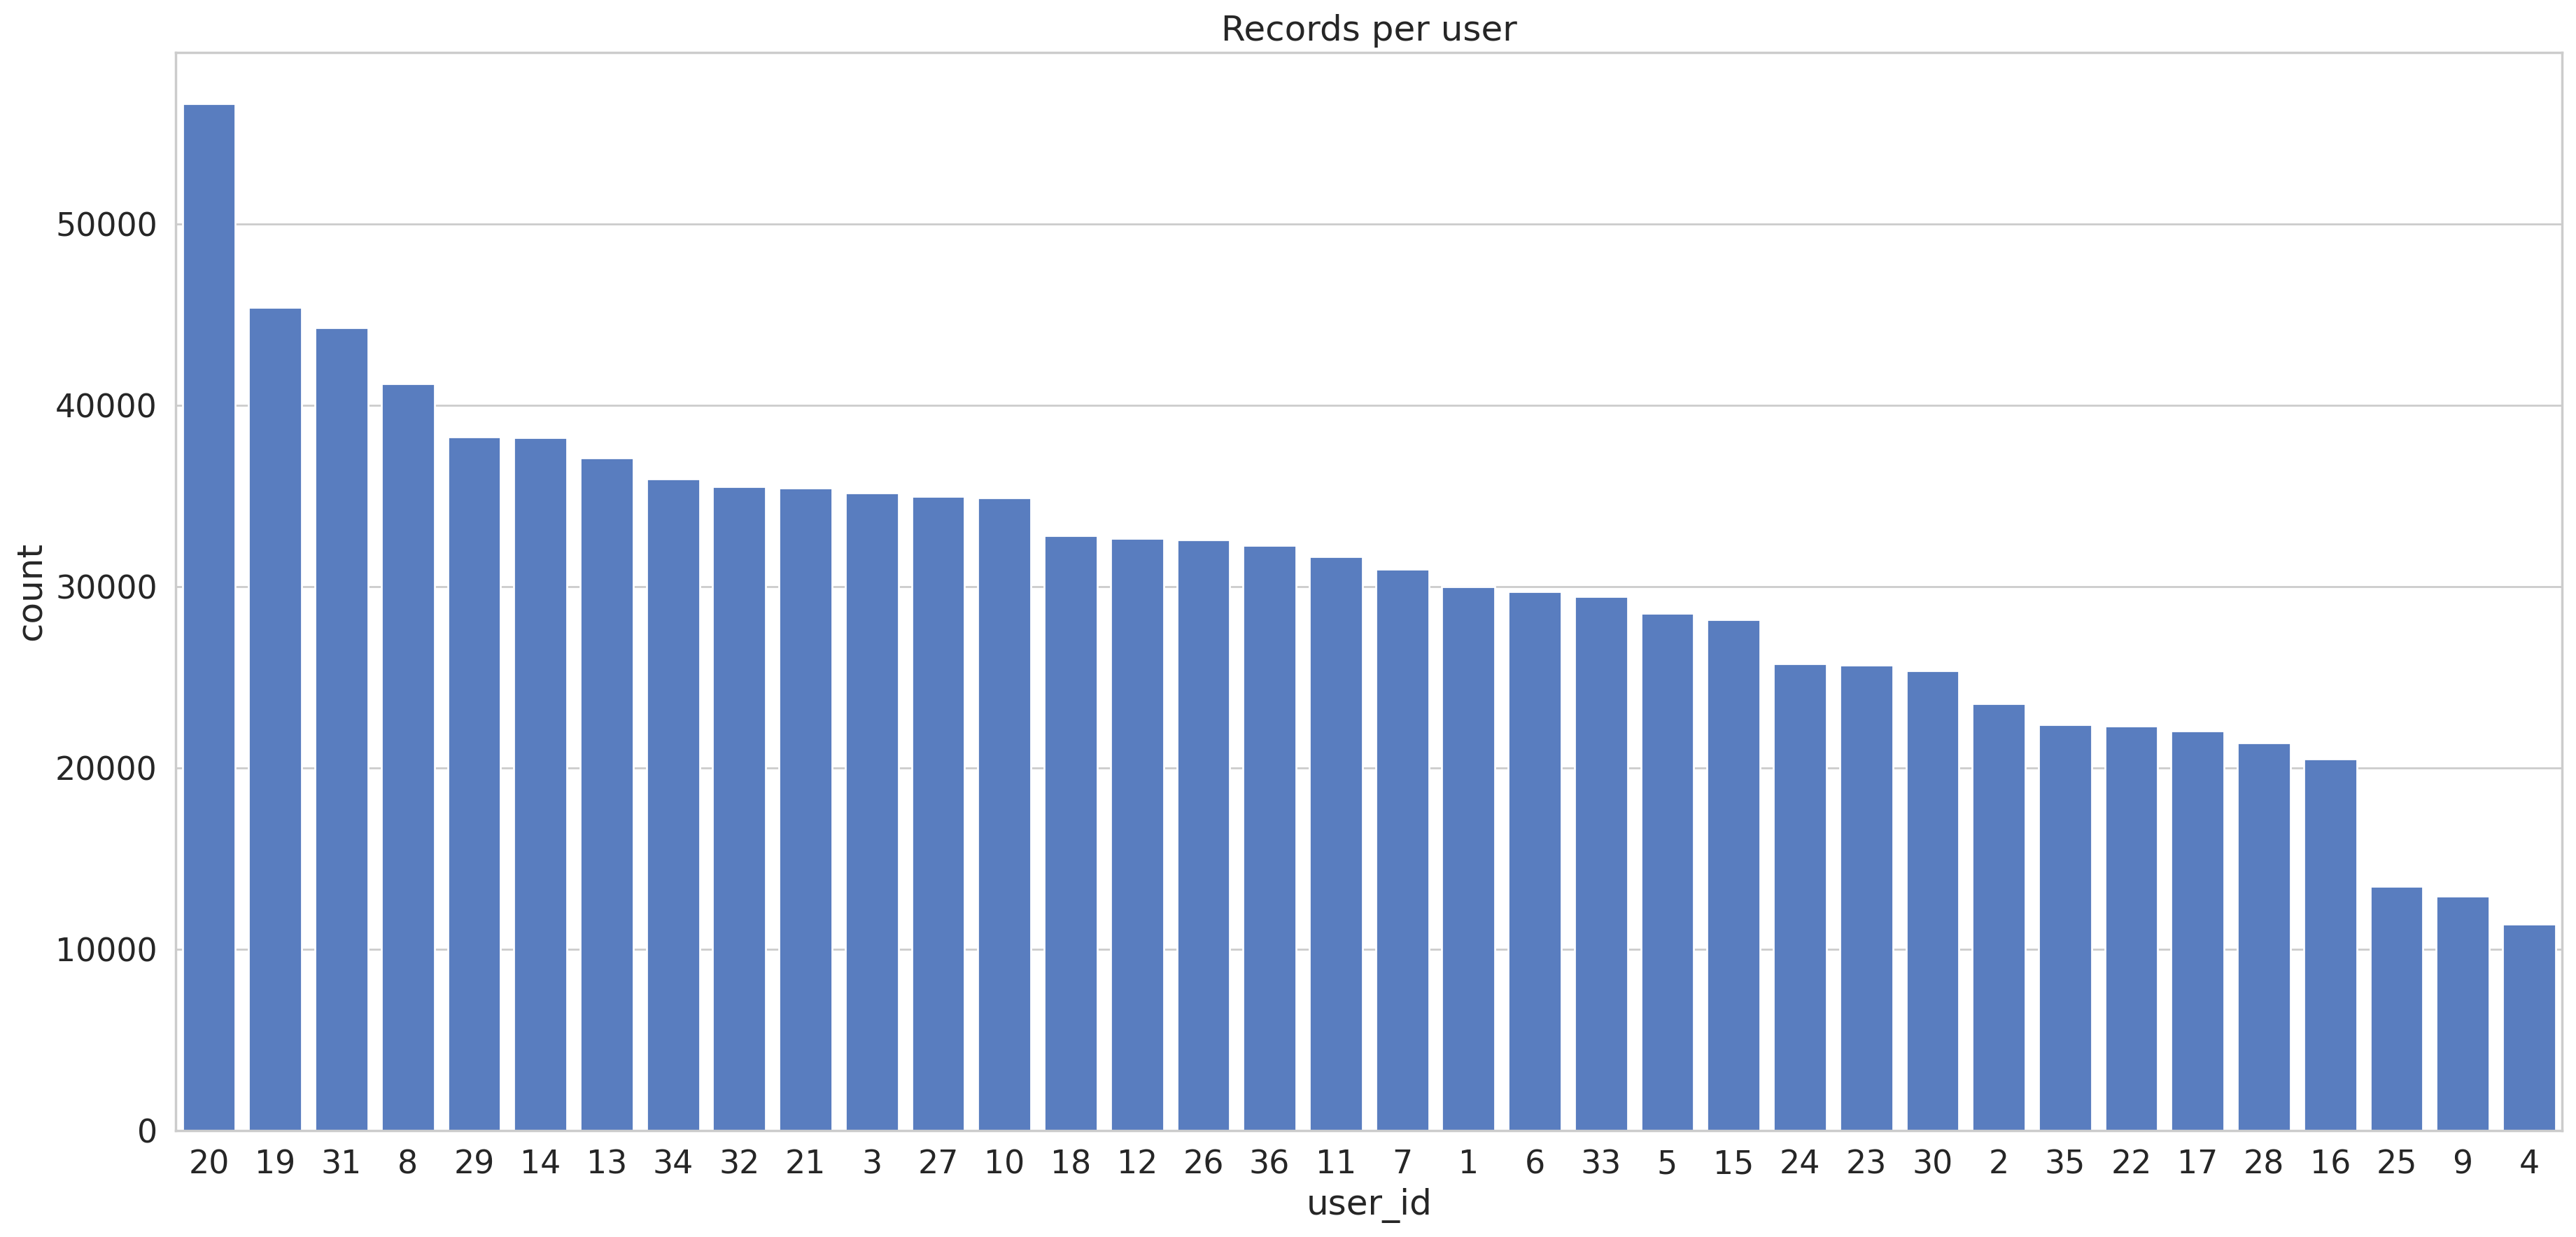

In [7]:
sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user");


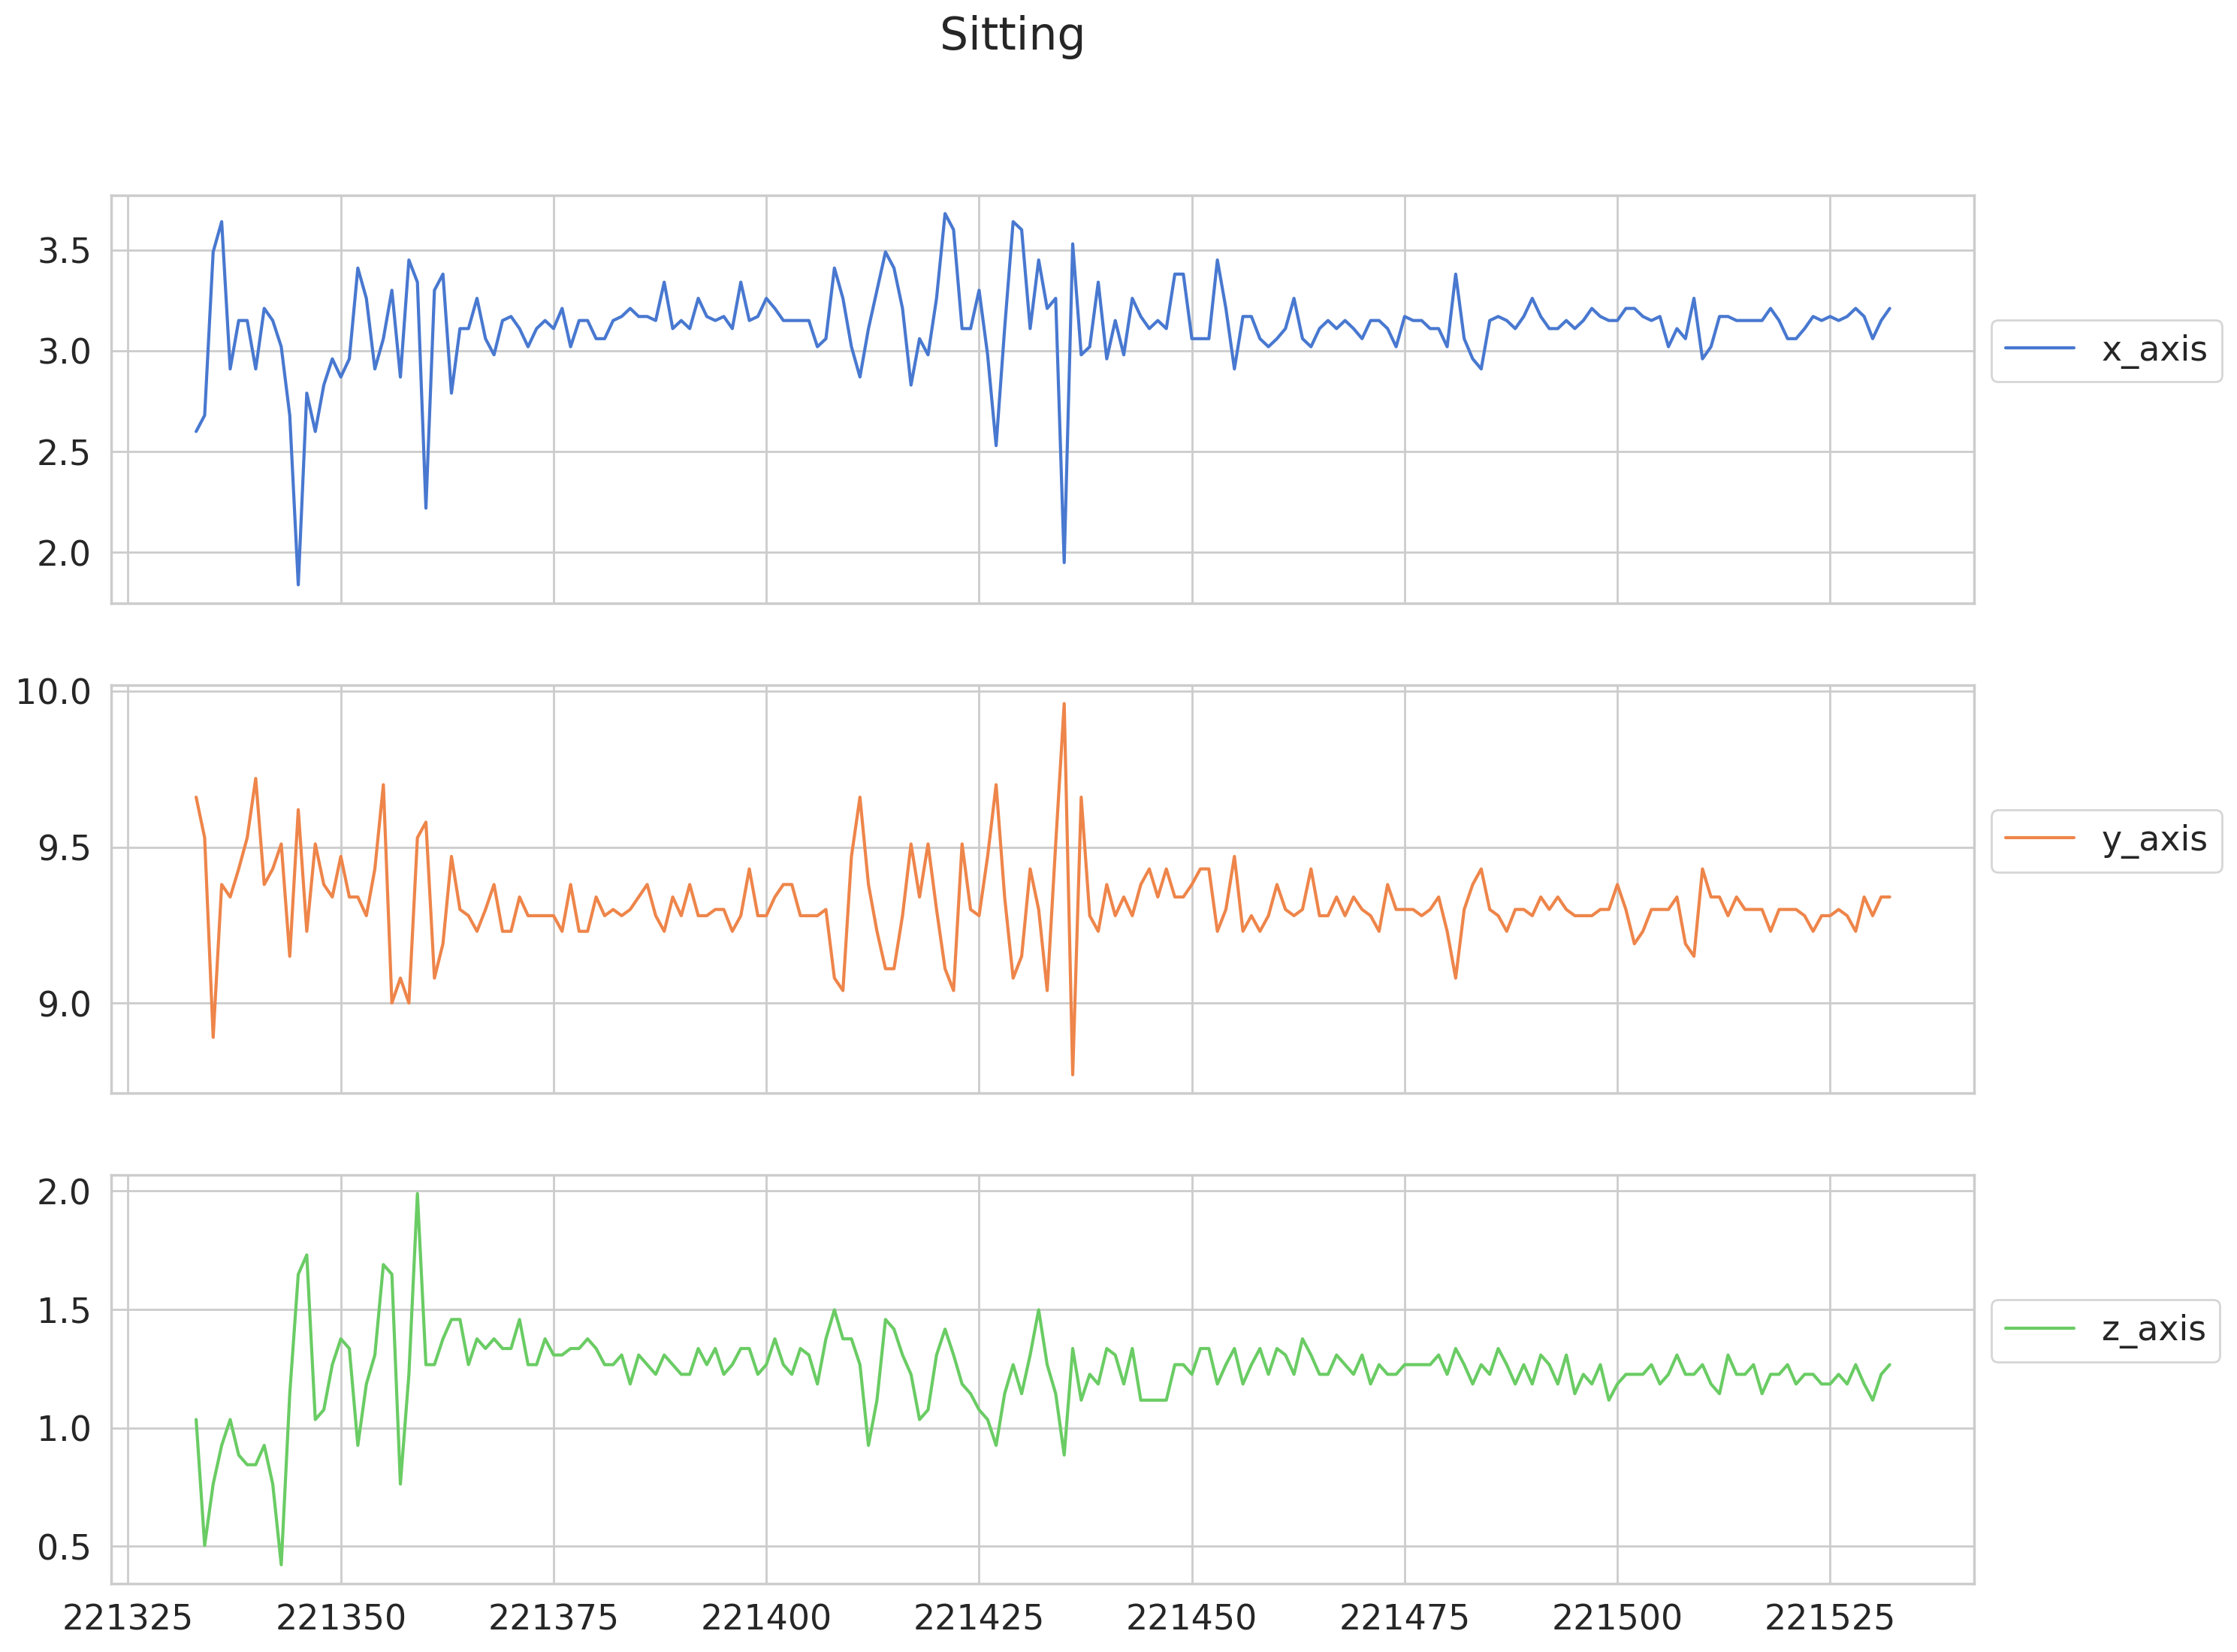

In [8]:

def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Sitting", df)


In [9]:
indexes = df[ (df['activity'] == 'Sitting') | (df['activity'] == 'Standing')].index
df.drop(indexes , inplace=True)


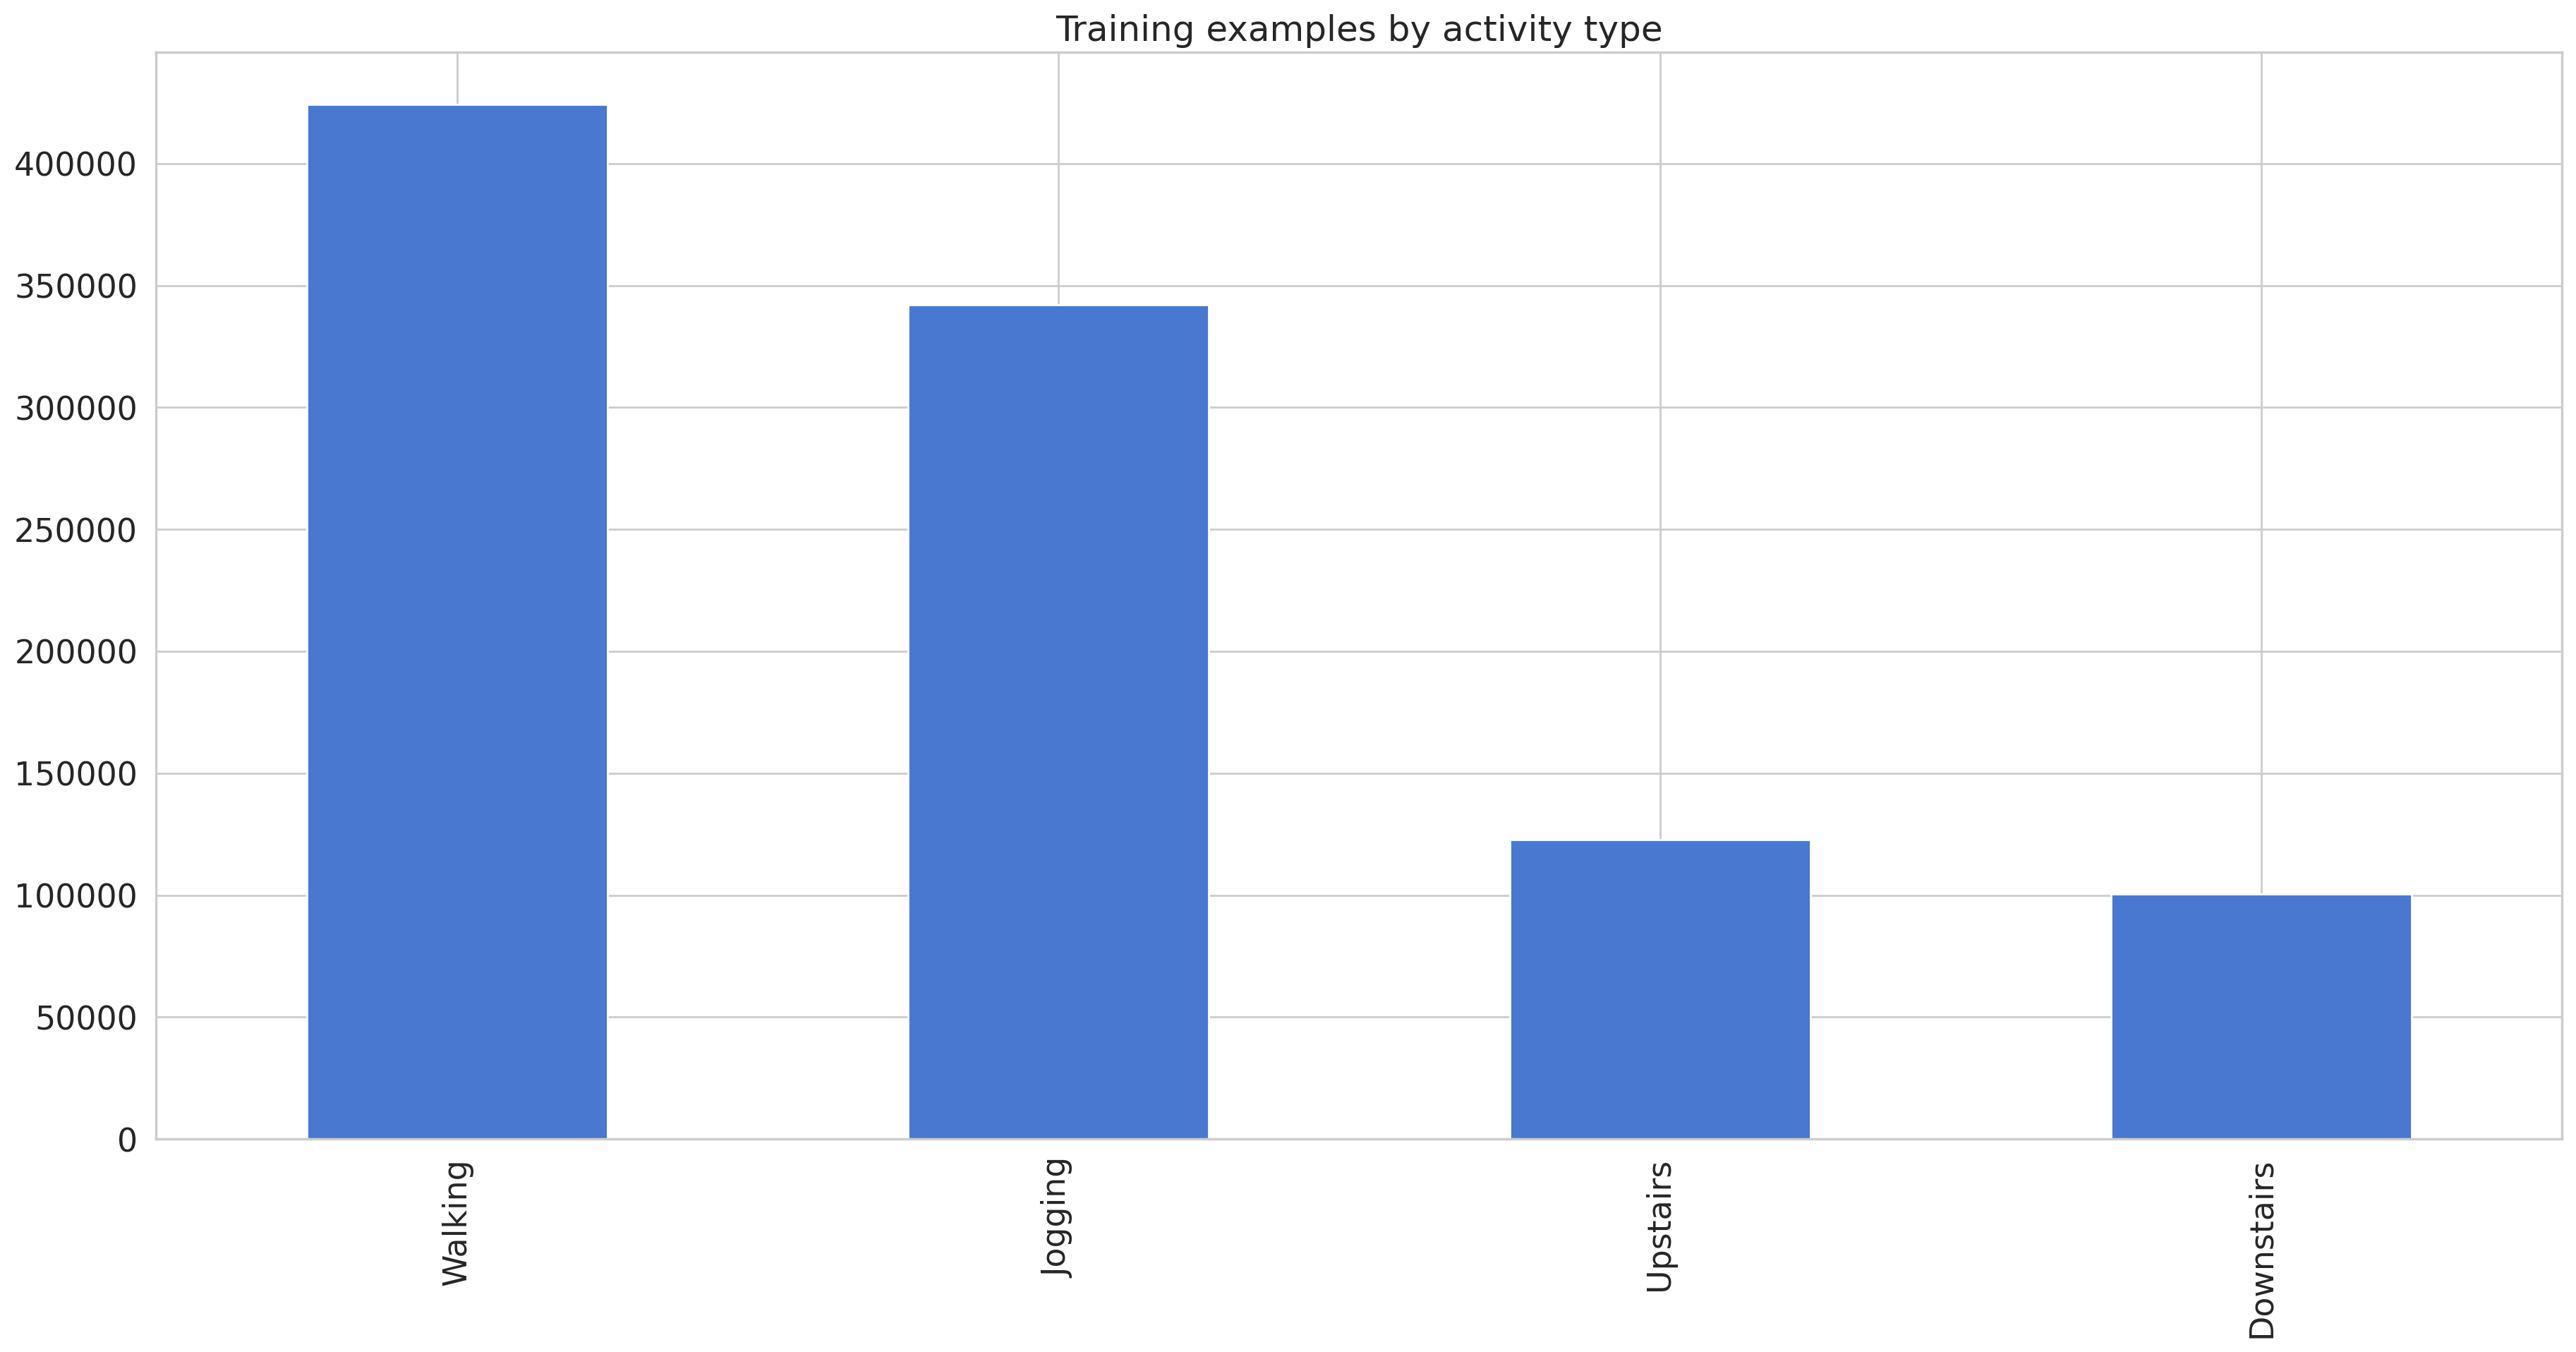

In [10]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

random_seed = 42

n_time_steps = 50

n_features = 3

step = 10

n_classes = 6

n_epochs = 50       

batch_size = 1024   

learning_rate = 0.0025

l2_loss = 0.0015


In [11]:
from sklearn.preprocessing import RobustScaler

scale_columns = ["x_axis", "y_axis", "z_axis"]

scaler = RobustScaler()

scaler = scaler.fit(df[scale_columns])

df.loc[:, scale_columns] = scaler.transform(df[scale_columns].to_numpy())
df

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


user_id    activity        timestamp    x_axis    y_axis    z_axis  \
0             33     Jogging   49105962326000 -0.139064  0.528798  0.162904   
1             33     Jogging   49106062271000  0.627996  0.365980  0.257510   
2             33     Jogging   49106112167000  0.613350  0.322145  0.039629   
3             33     Jogging   49106222305000 -0.128080  1.197291  0.693271   
4             33     Jogging   49106332290000 -0.204969  0.463045  1.573395   
...          ...         ...              ...       ...       ...       ...   
1093534       19  Downstairs  131357151521000 -0.602151 -0.017241  0.635659   
1093535       19  Downstairs  131357191438000 -0.987903  0.155172  0.248370   
1093536       19  Downstairs  131357231630000 -1.235215  0.718391  0.119975   
1093537       19  Downstairs  131357271516000 -1.065860  0.026437 -0.524103   
1093538       19  Downstairs  131357351686000 -0.977151 -0.510345 -0.103137   

         ActivityEncoded  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
...                  ...  
1093534                3  
1093535                3  
1093536                3  
1093537                3  
1093538                3  

[989870 rows x 7 columns]

In [12]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 50
STEP = 10

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)

X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(63348, 50, 3) (63348, 1)
(19797, 50, 3) (19797, 1)


In [13]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(63348, 50, 3) (63348, 4) (19797, 50, 3) (19797, 4)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:

batch_size = 1024
learning_rate = 0.0025
l2_loss = 0.0015
n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(50, 3, 4)

# LSTM1


In [ ]:
model = Sequential()
# RNN layer
model.add(Bidirectional(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]))))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 256)               135168    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 151876 (593.27 KB)
Trainable params: 151876 (593.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# validation_split = 0.1
batch_size = 1024

train_epochs = 10

history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
62/62 [==============================] - 101s 2s/step - loss: 0.9379 - accuracy: 0.6535 - val_loss: 0.6457 - val_accuracy: 0.7724
Epoch 2/10
62/62 [==============================] - 96s 2s/step - loss: 0.5944 - accuracy: 0.7865 - val_loss: 0.5278 - val_accuracy: 0.8025
Epoch 3/10
62/62 [==============================] - 98s 2s/step - loss: 0.5009 - accuracy: 0.8150 - val_loss: 0.4544 - val_accuracy: 0.8353
Epoch 4/10
62/62 [==============================] - 94s 2s/step - loss: 0.4232 - accuracy: 0.8415 - val_loss: 0.3874 - val_accuracy: 0.8550
Epoch 5/10
62/62 [==============================] - 95s 2s/step - loss: 0.3694 - accuracy: 0.8609 - val_loss: 0.3363 - val_accuracy: 0.8745
Epoch 6/10
62/62 [==============================] - 94s 2s/step - loss: 0.3262 - accuracy: 0.8776 - val_loss: 0.2890 - val_accuracy: 0.8958
Epoch 7/10
62/62 [==============================] - 94s 2s/step - loss: 0.2914 - accuracy: 0.8928 - val_loss: 0.2724 - val_accuracy: 0.9029
Epoch 8/10
62/62 [=

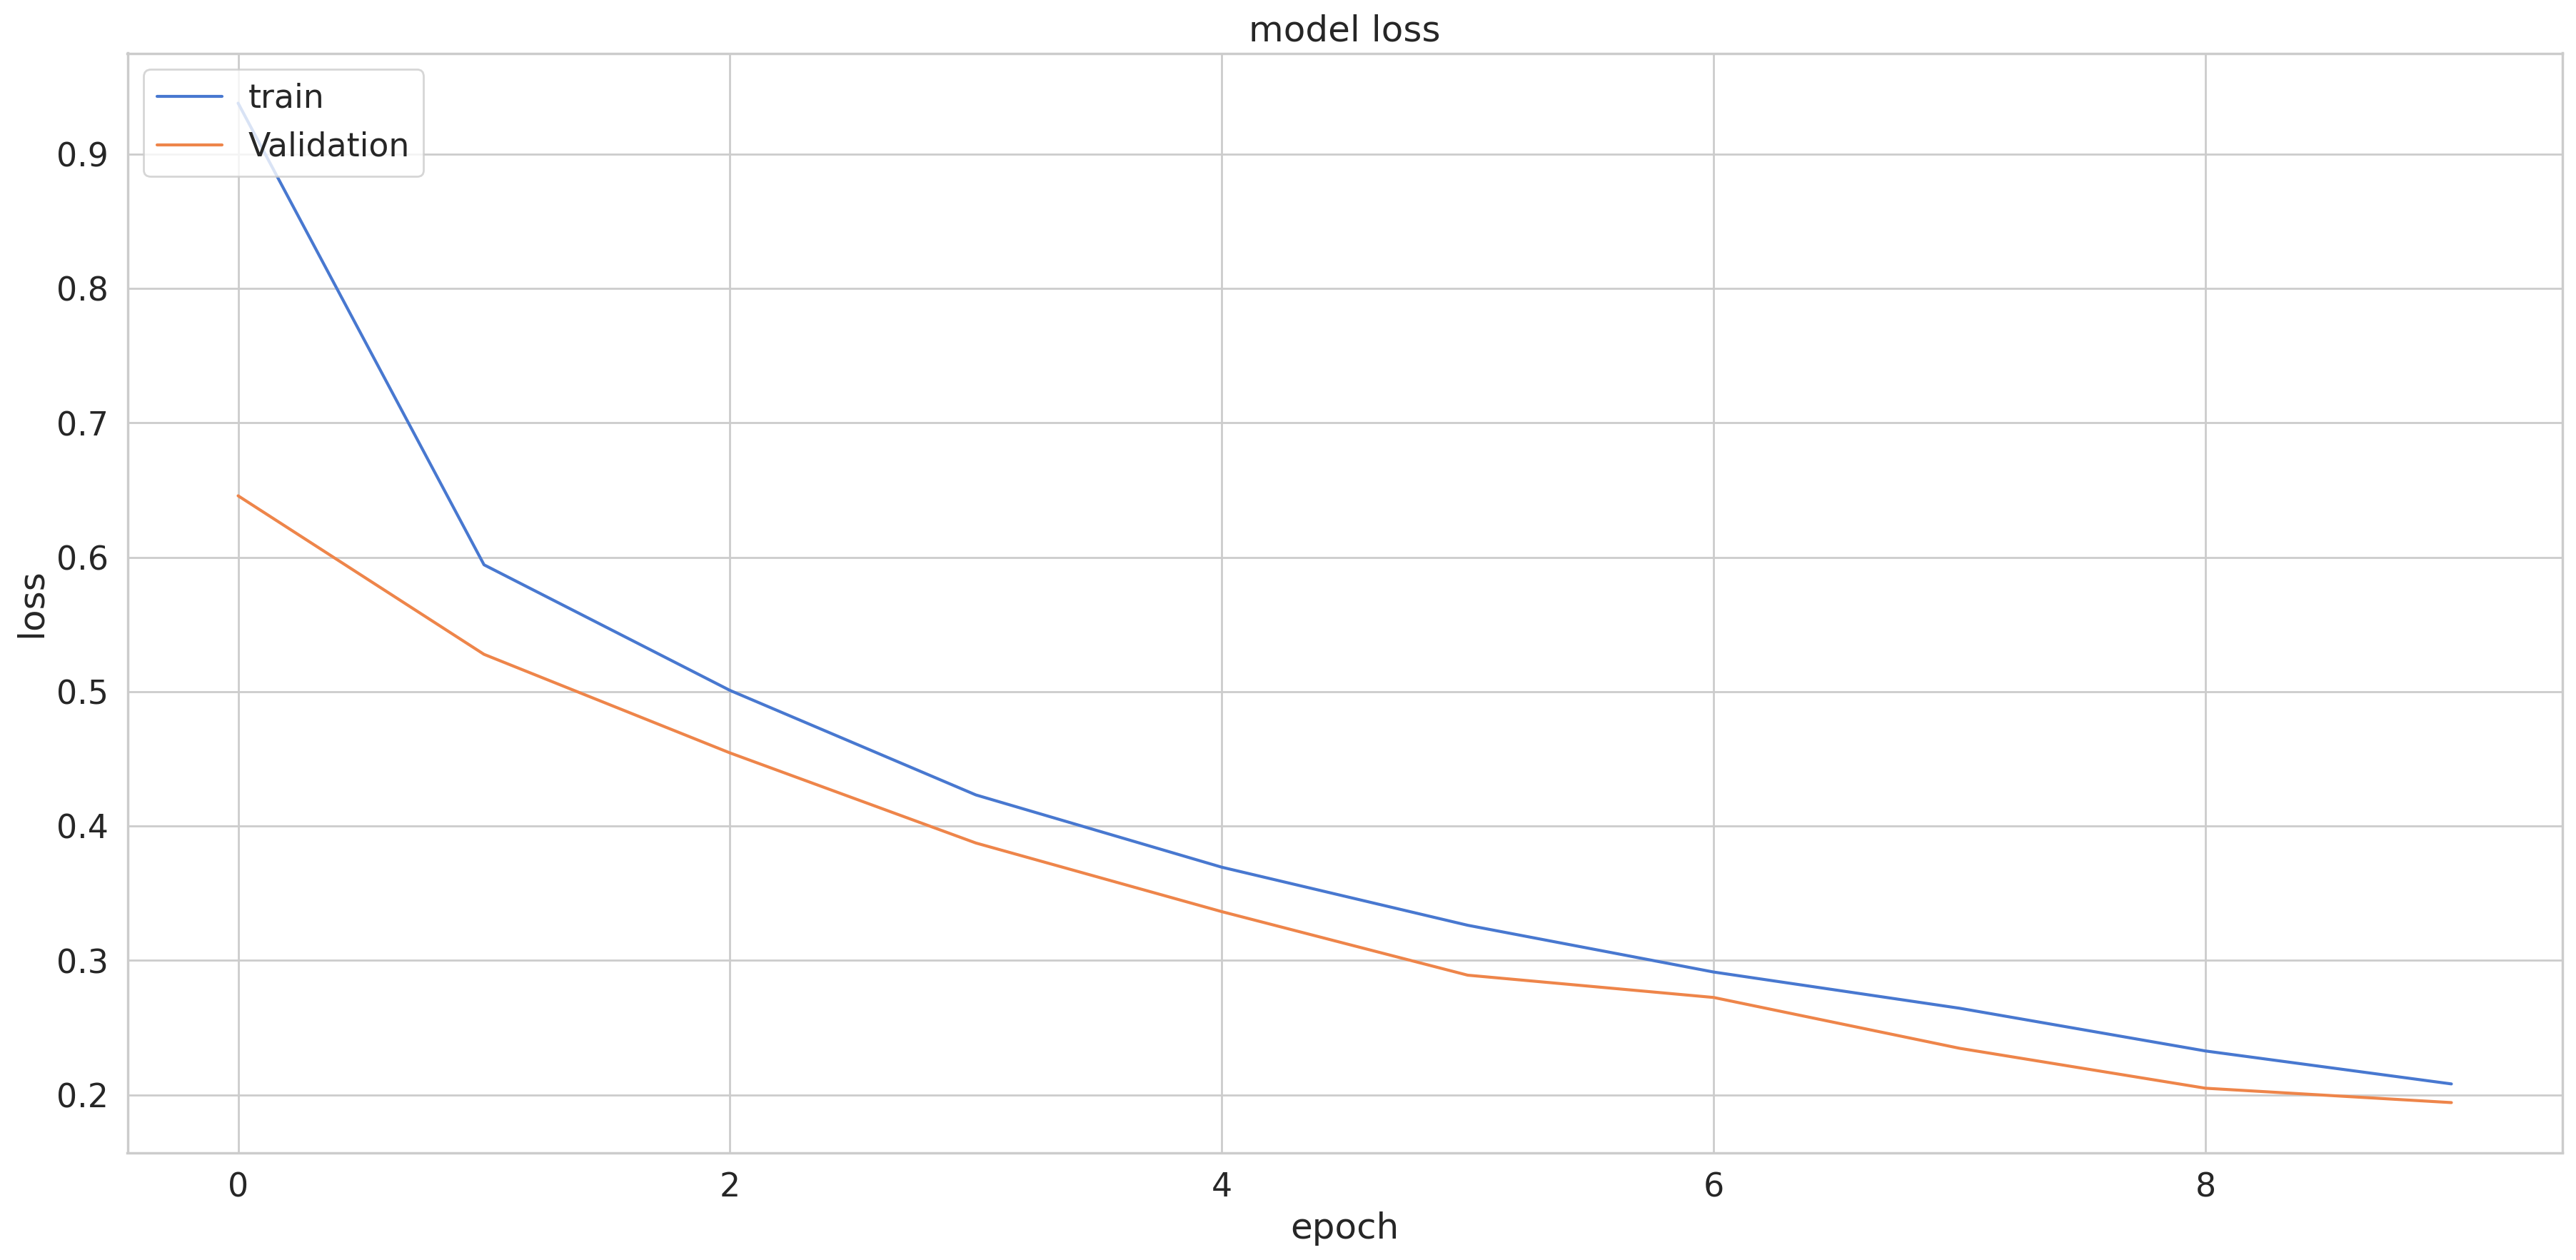

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

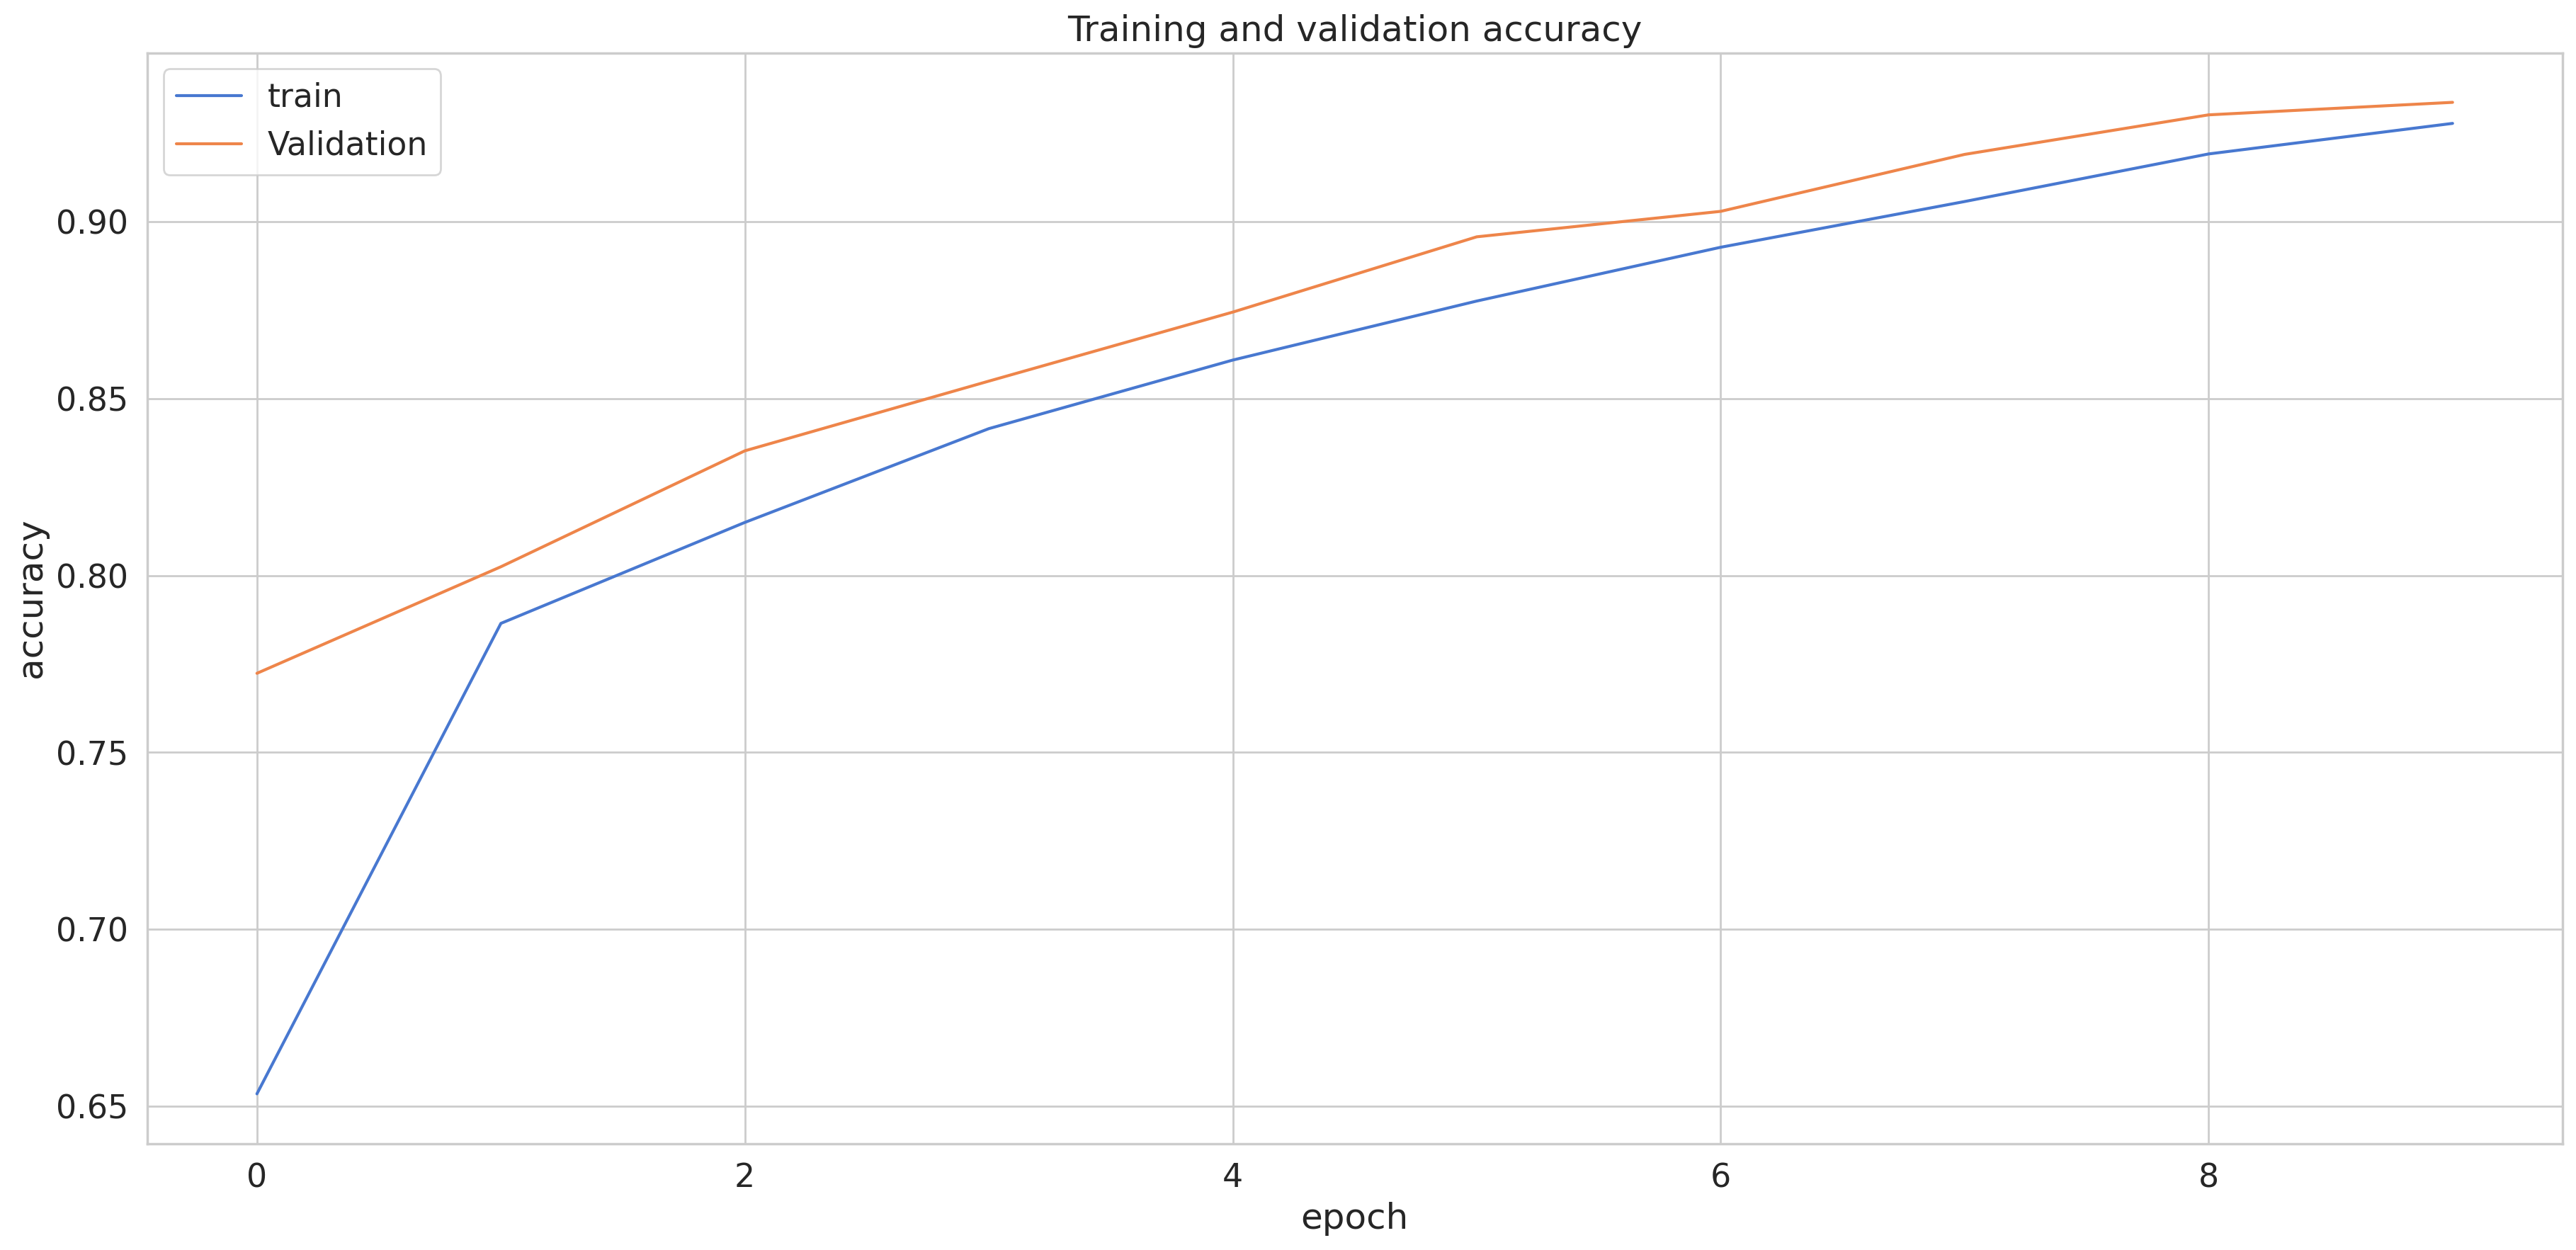

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

619/619 [==============================] - 24s 38ms/step
f1_score =  0.9300010584061262
0.9314542607465778
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      8490
           1       0.97      0.98      0.98      6843
           2       0.84      0.76      0.80      2459
           3       0.83      0.78      0.80      2005

    accuracy                           0.93     19797
   macro avg       0.90      0.87      0.88     19797
weighted avg       0.93      0.93      0.93     19797



<Axes: >

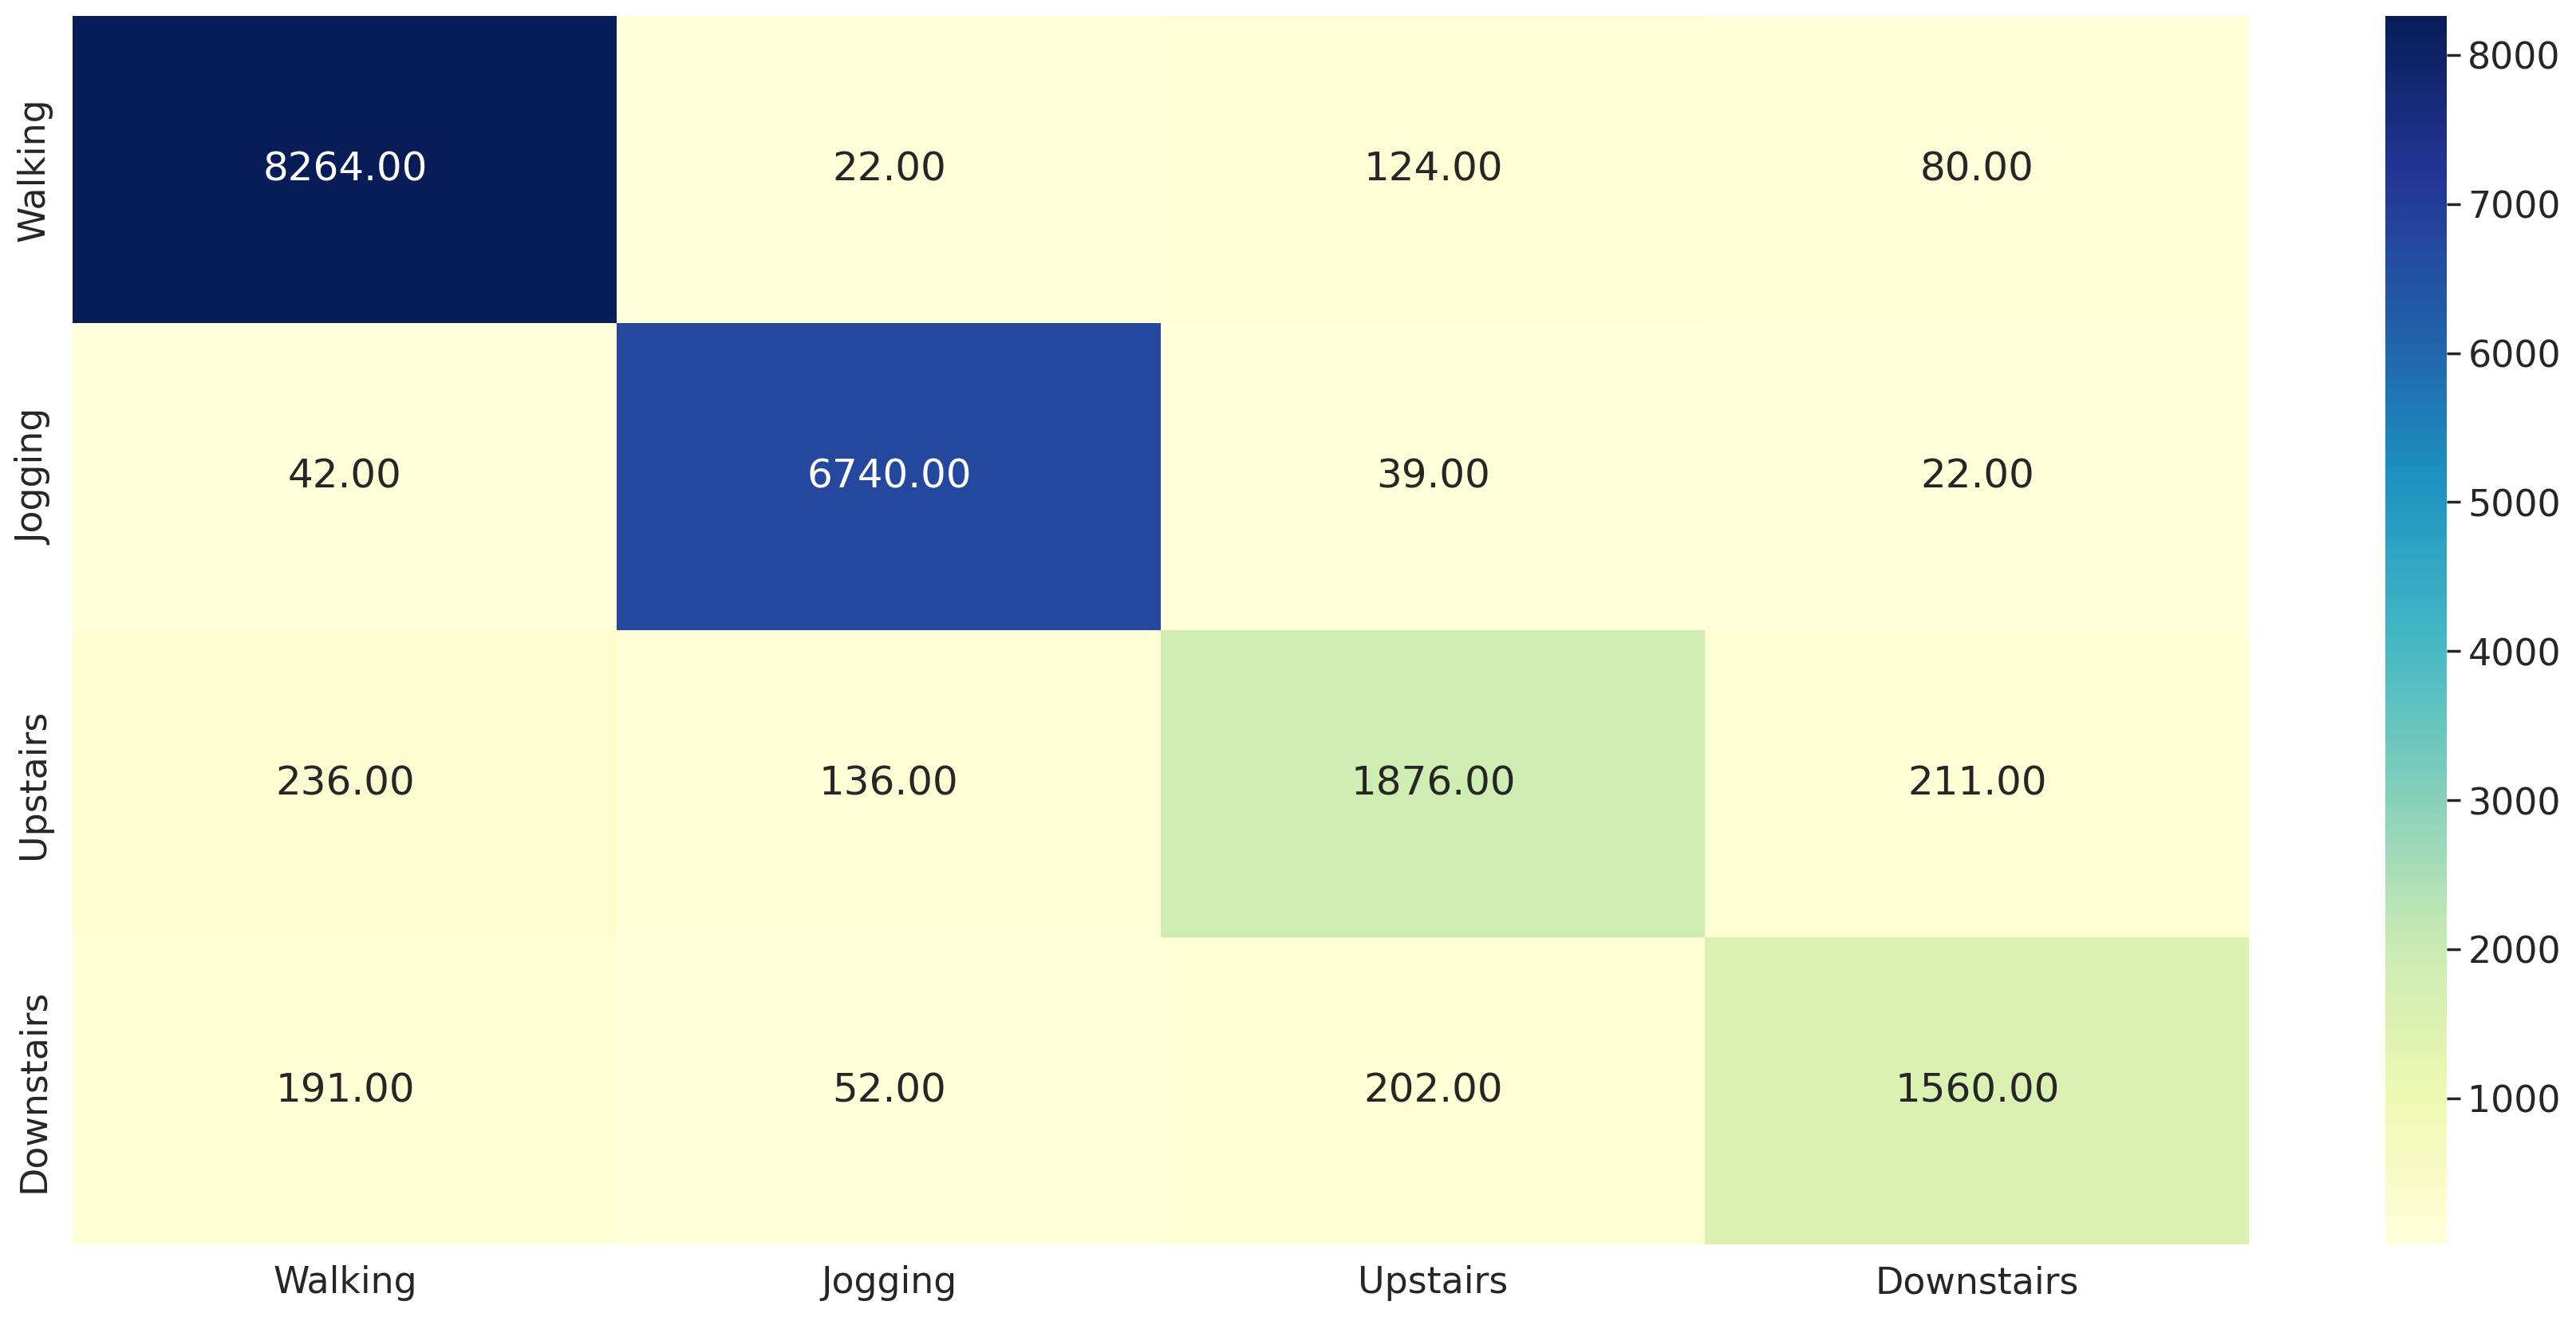

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM2

In [ ]:
model = Sequential()
# RNN layer
model.add(Bidirectional(LSTM(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2]))))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

# Display model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 50, 256)           135168    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 50, 256)           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 4)                

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
495/495 [==============================] - 394s 780ms/step - loss: 0.5545 - accuracy: 0.7984 - val_loss: 0.3103 - val_accuracy: 0.8857
Epoch 2/10
495/495 [==============================] - 389s 787ms/step - loss: 0.2468 - accuracy: 0.9123 - val_loss: 0.1800 - val_accuracy: 0.9392
Epoch 3/10
495/495 [==============================] - 393s 795ms/step - loss: 0.1556 - accuracy: 0.9469 - val_loss: 0.1201 - val_accuracy: 0.9607
Epoch 4/10
495/495 [==============================] - 382s 771ms/step - loss: 0.1196 - accuracy: 0.9606 - val_loss: 0.0997 - val_accuracy: 0.9675
Epoch 5/10
495/495 [==============================] - 394s 796ms/step - loss: 0.0948 - accuracy: 0.9687 - val_loss: 0.0979 - val_accuracy: 0.9694
Epoch 6/10
495/495 [==============================] - 392s 793ms/step - loss: 0.0826 - accuracy: 0.9726 - val_loss: 0.0727 - val_accuracy: 0.9759
Epoch 7/10
495/495 [==============================] - 396s 801ms/step - loss: 0.0716 - accuracy: 0.9756 - val_loss: 0.0760 -

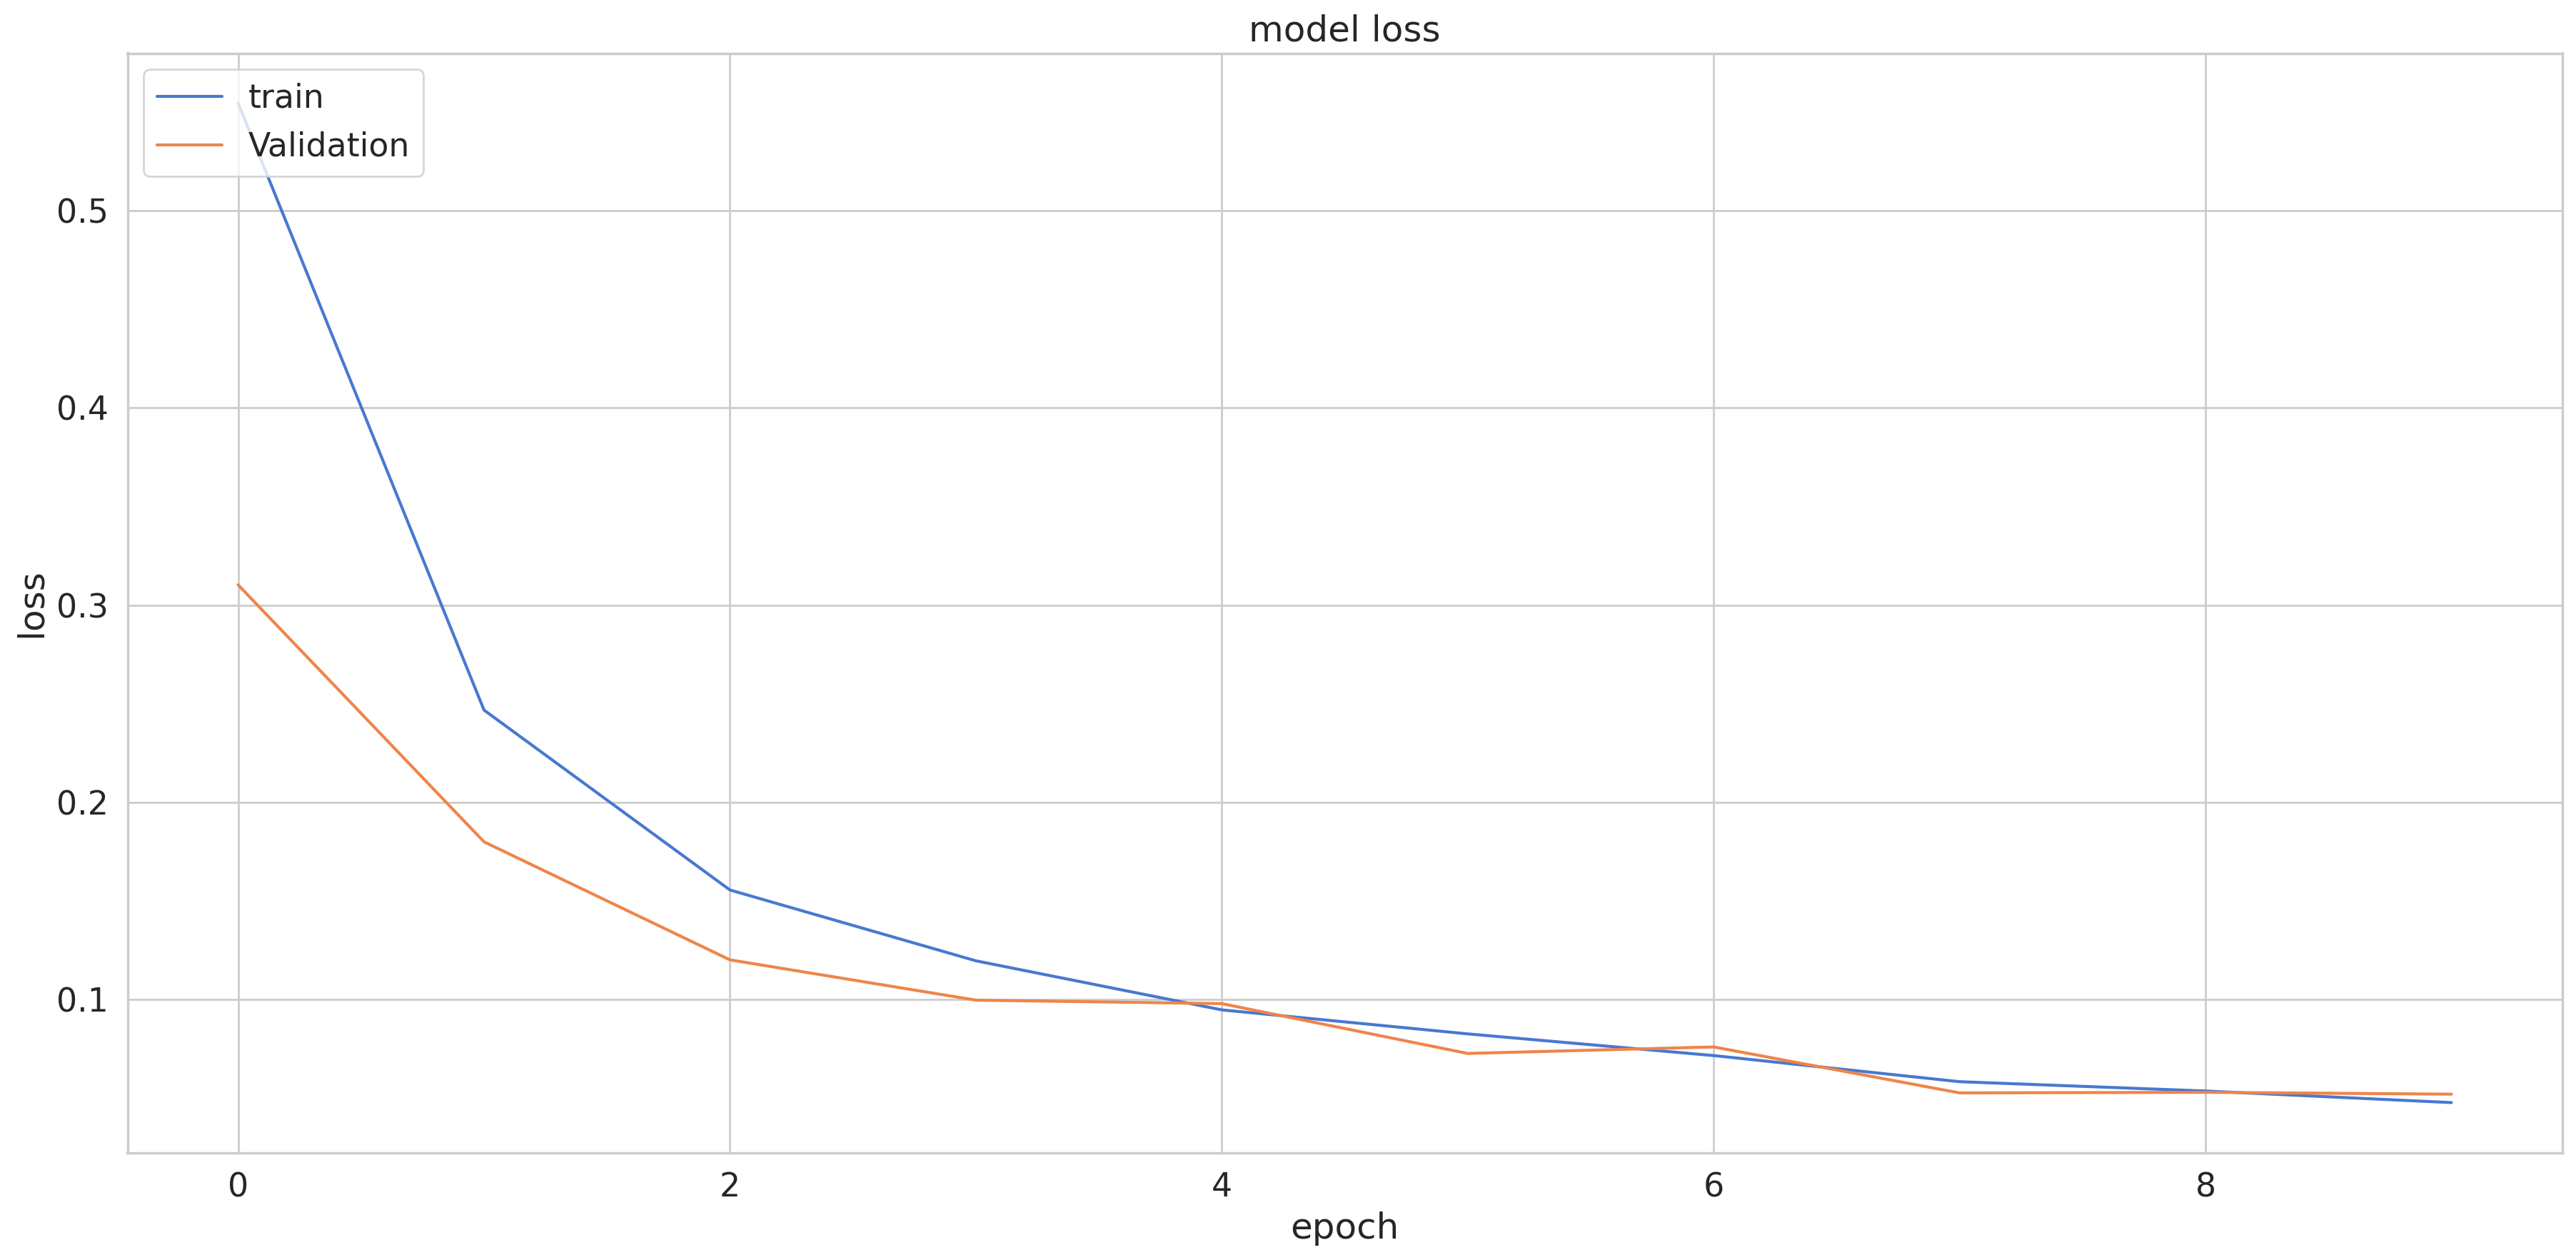

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

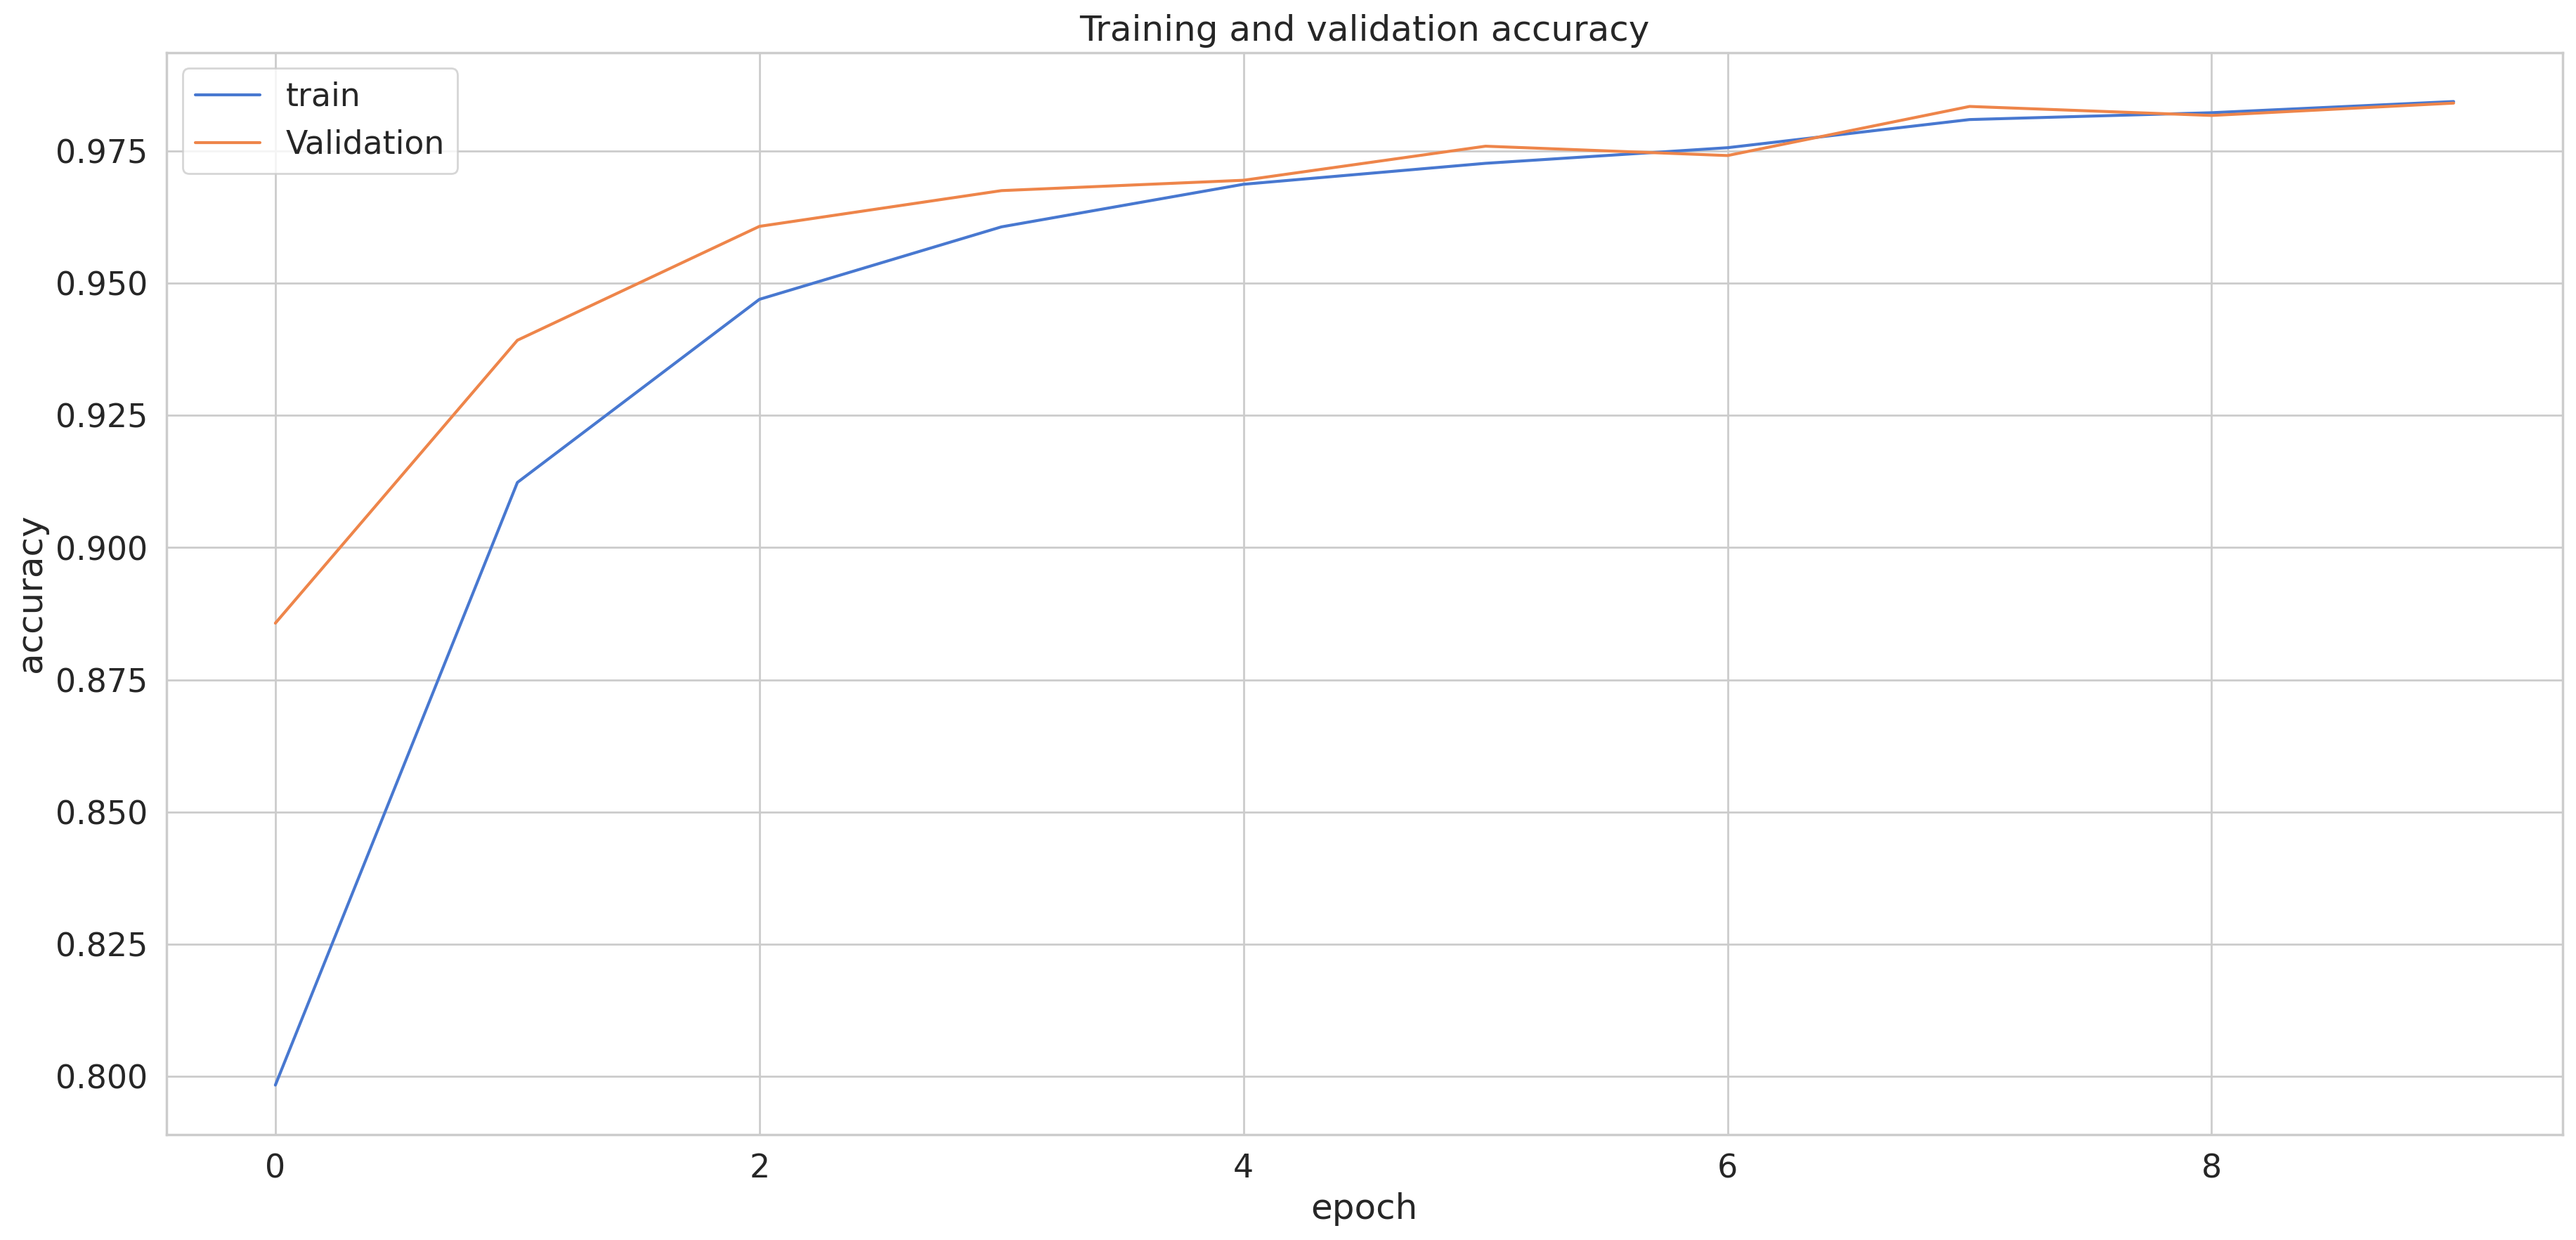

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

619/619 [==============================] - 67s 106ms/step
f1_score =  0.9832052090792535
0.9831287568823559
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      8490
           1       0.99      0.99      0.99      6843
           2       0.95      0.96      0.95      2459
           3       0.94      0.96      0.95      2005

    accuracy                           0.98     19797
   macro avg       0.97      0.97      0.97     19797
weighted avg       0.98      0.98      0.98     19797



<Axes: >

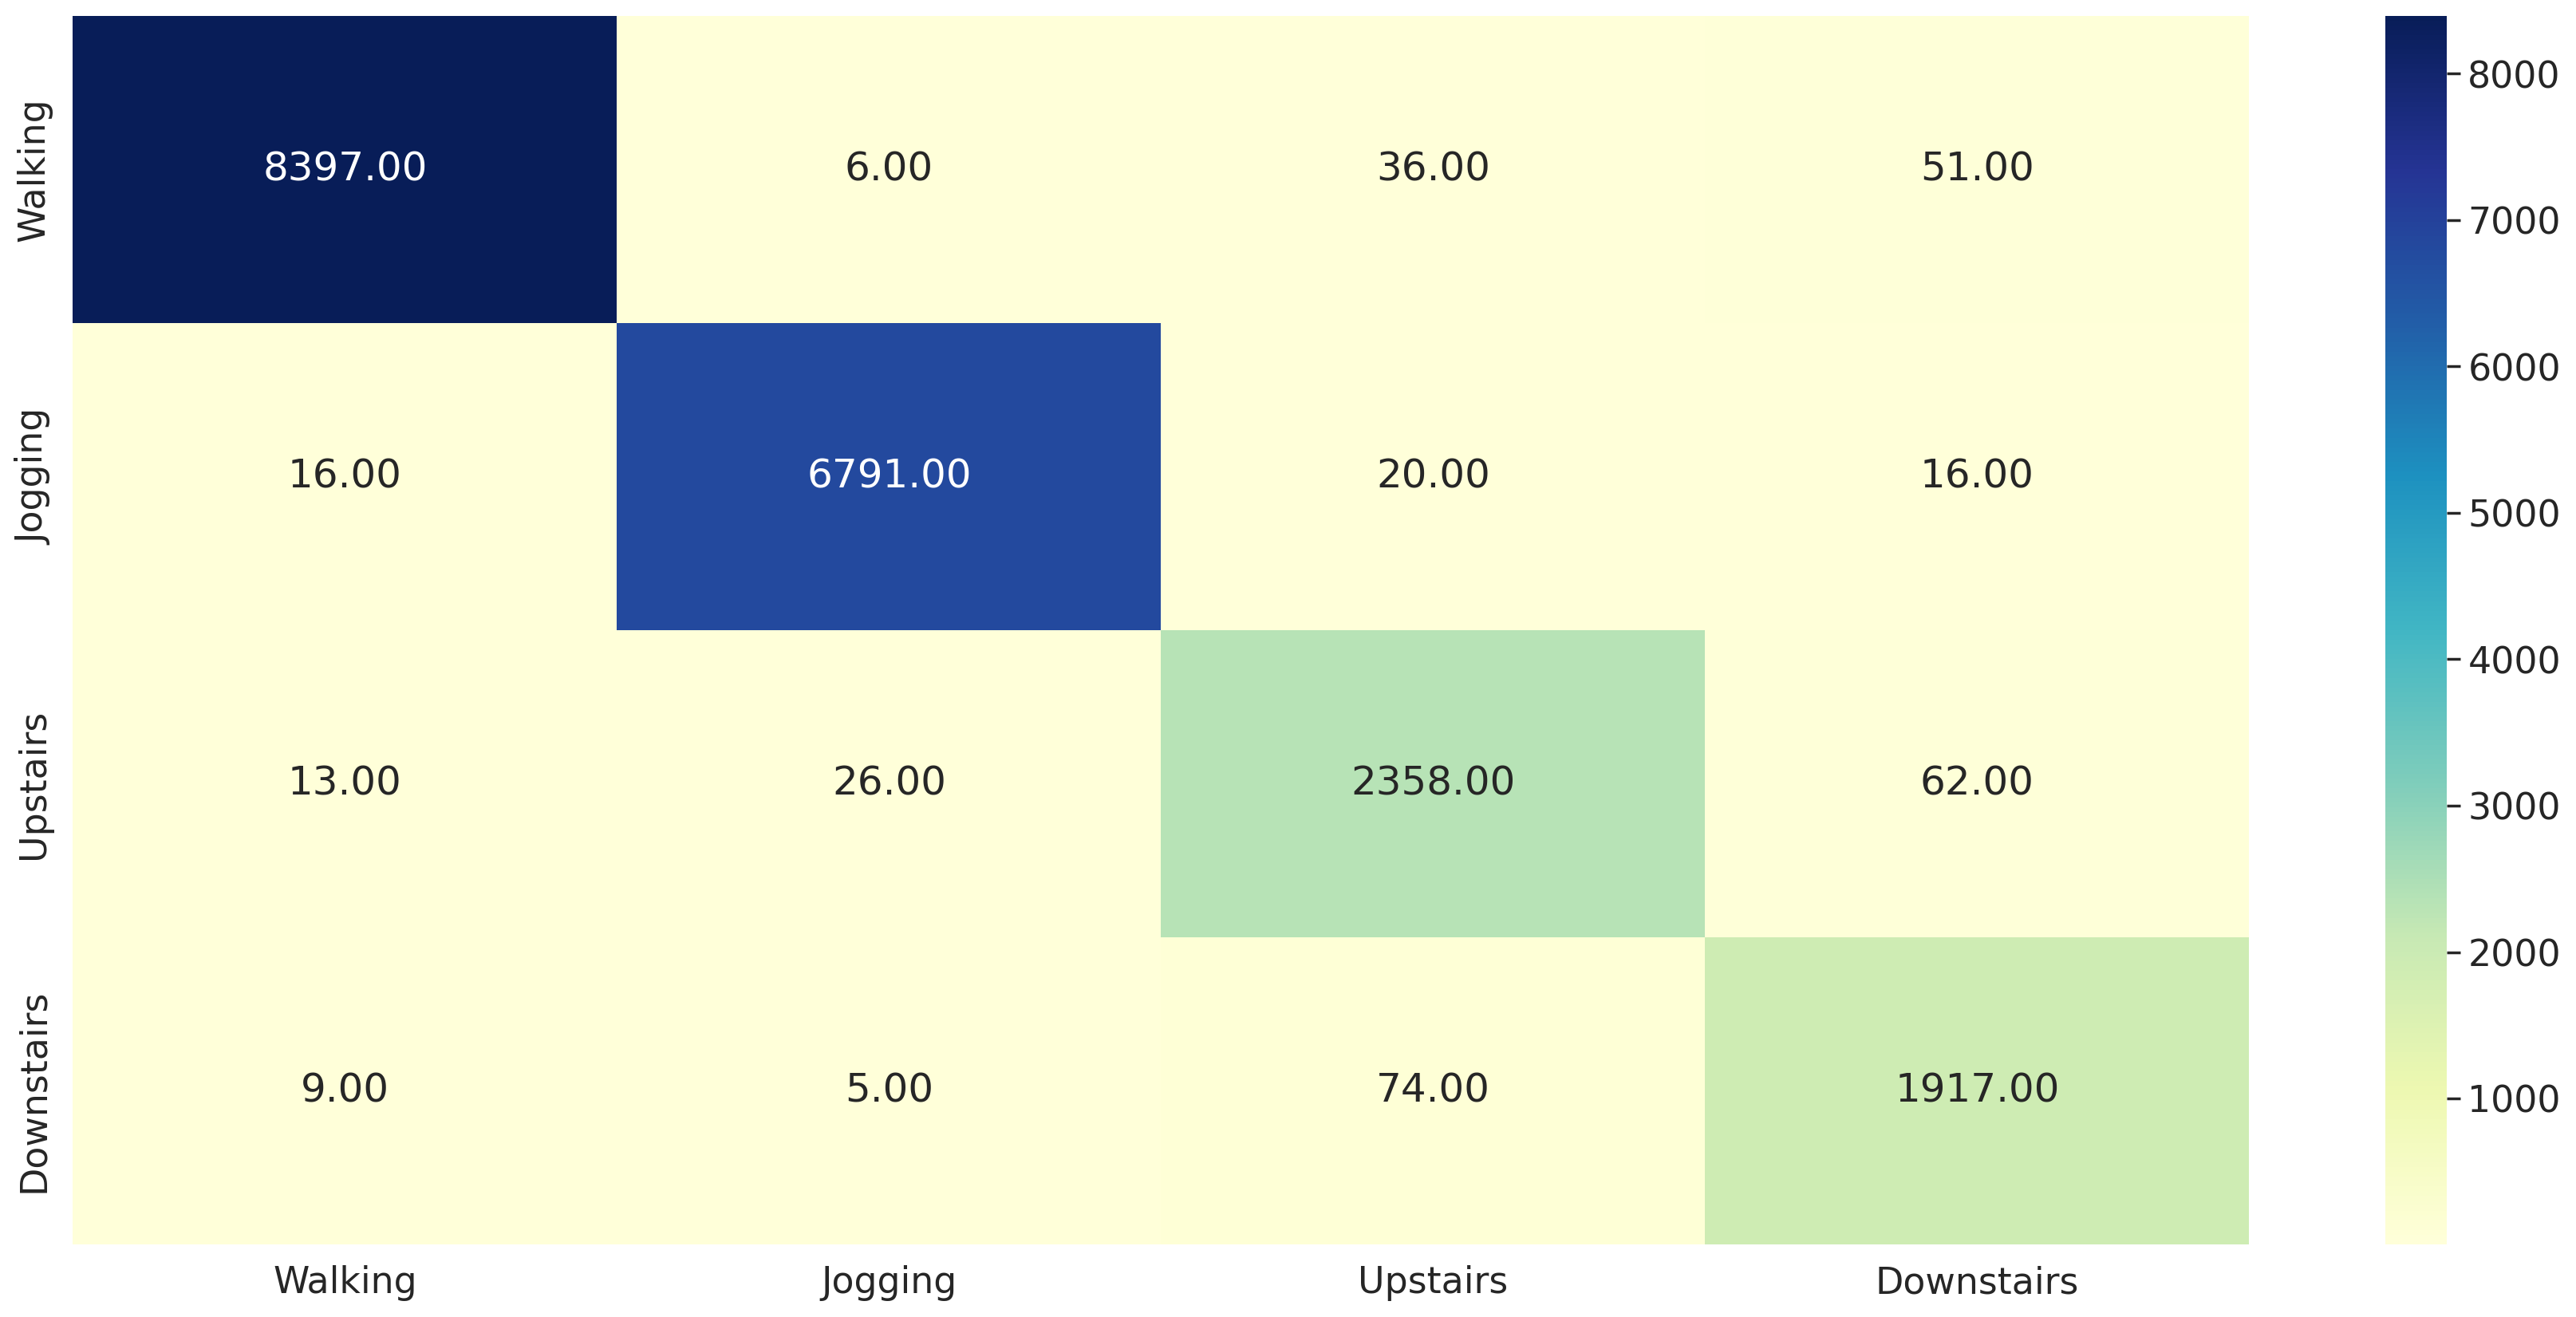

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM3

In [ ]:
model = Sequential()
# RNN layer
model.add(Bidirectional(LSTM(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2]))))
# Dropout layer
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

# Display model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirecti  (None, 50, 256)           135168    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 50, 256)           0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 50, 256)           394240    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 50, 256)           0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                      

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
495/495 [==============================] - 690s 1s/step - loss: 0.5359 - accuracy: 0.8078 - val_loss: 0.2757 - val_accuracy: 0.9023
Epoch 2/10
495/495 [==============================] - 645s 1s/step - loss: 0.2270 - accuracy: 0.9225 - val_loss: 0.1546 - val_accuracy: 0.9490
Epoch 3/10
495/495 [==============================] - 673s 1s/step - loss: 0.1499 - accuracy: 0.9513 - val_loss: 0.1099 - val_accuracy: 0.9632
Epoch 4/10
495/495 [==============================] - 675s 1s/step - loss: 0.1124 - accuracy: 0.9624 - val_loss: 0.0982 - val_accuracy: 0.9663
Epoch 5/10
495/495 [==============================] - 681s 1s/step - loss: 0.0873 - accuracy: 0.9708 - val_loss: 0.0723 - val_accuracy: 0.9764
Epoch 6/10
495/495 [==============================] - 673s 1s/step - loss: 0.0711 - accuracy: 0.9768 - val_loss: 0.0930 - val_accuracy: 0.9696
Epoch 7/10
495/495 [==============================] - 676s 1s/step - loss: 0.0627 - accuracy: 0.9793 - val_loss: 0.0577 - val_accuracy: 0.9809

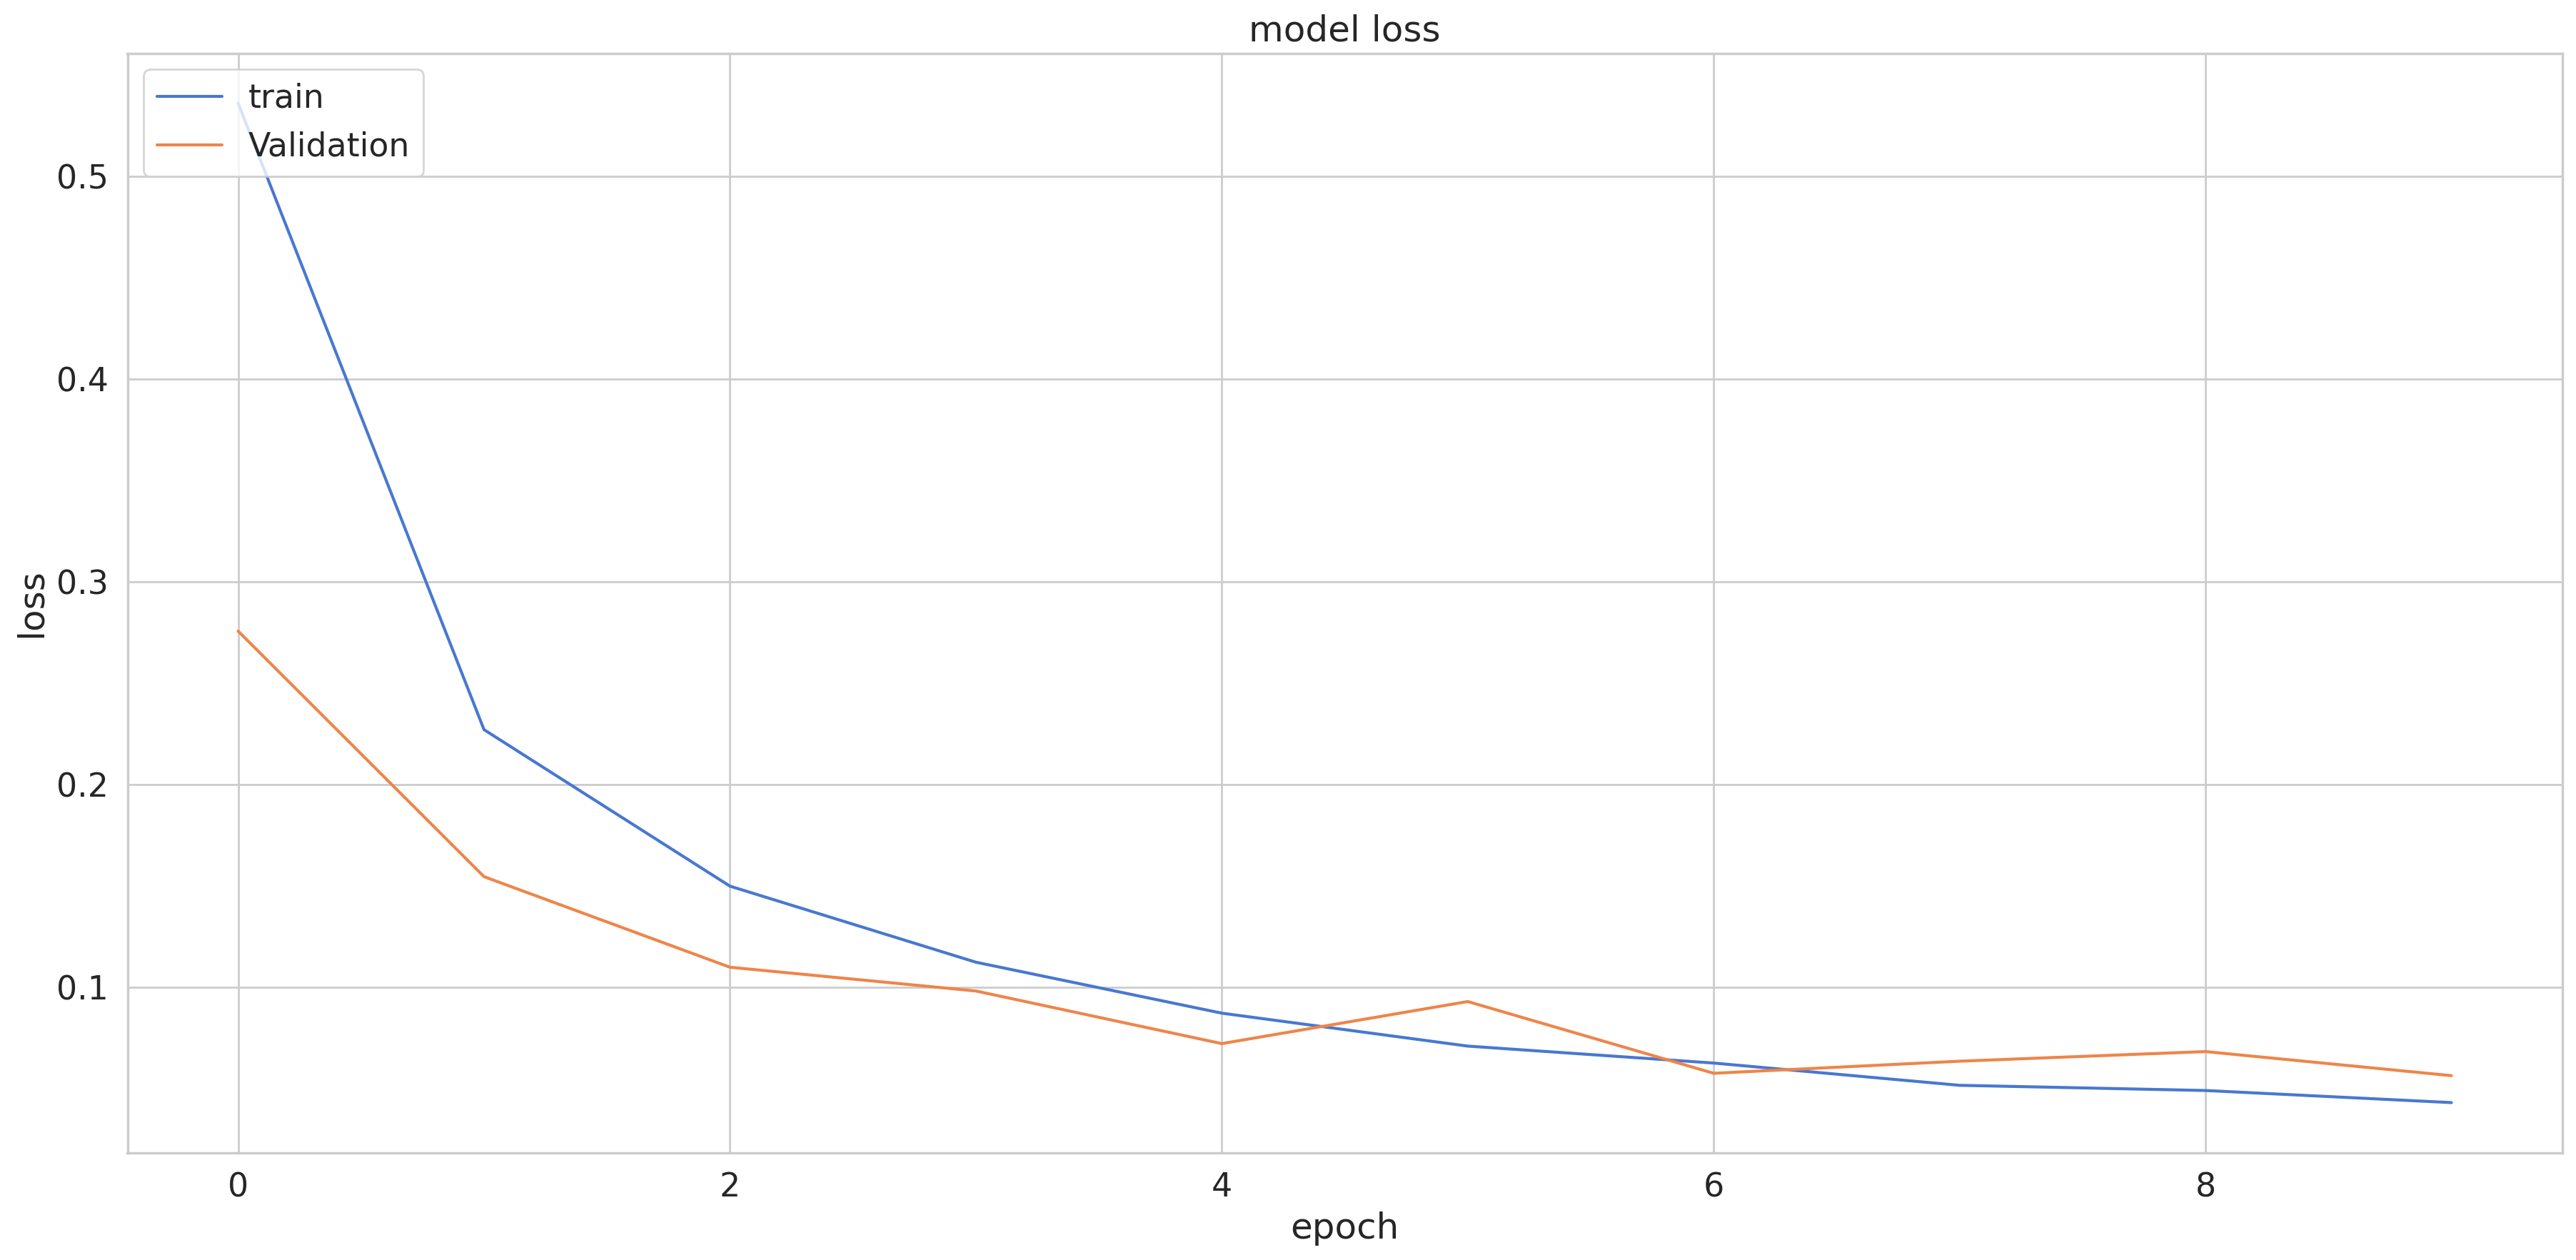

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

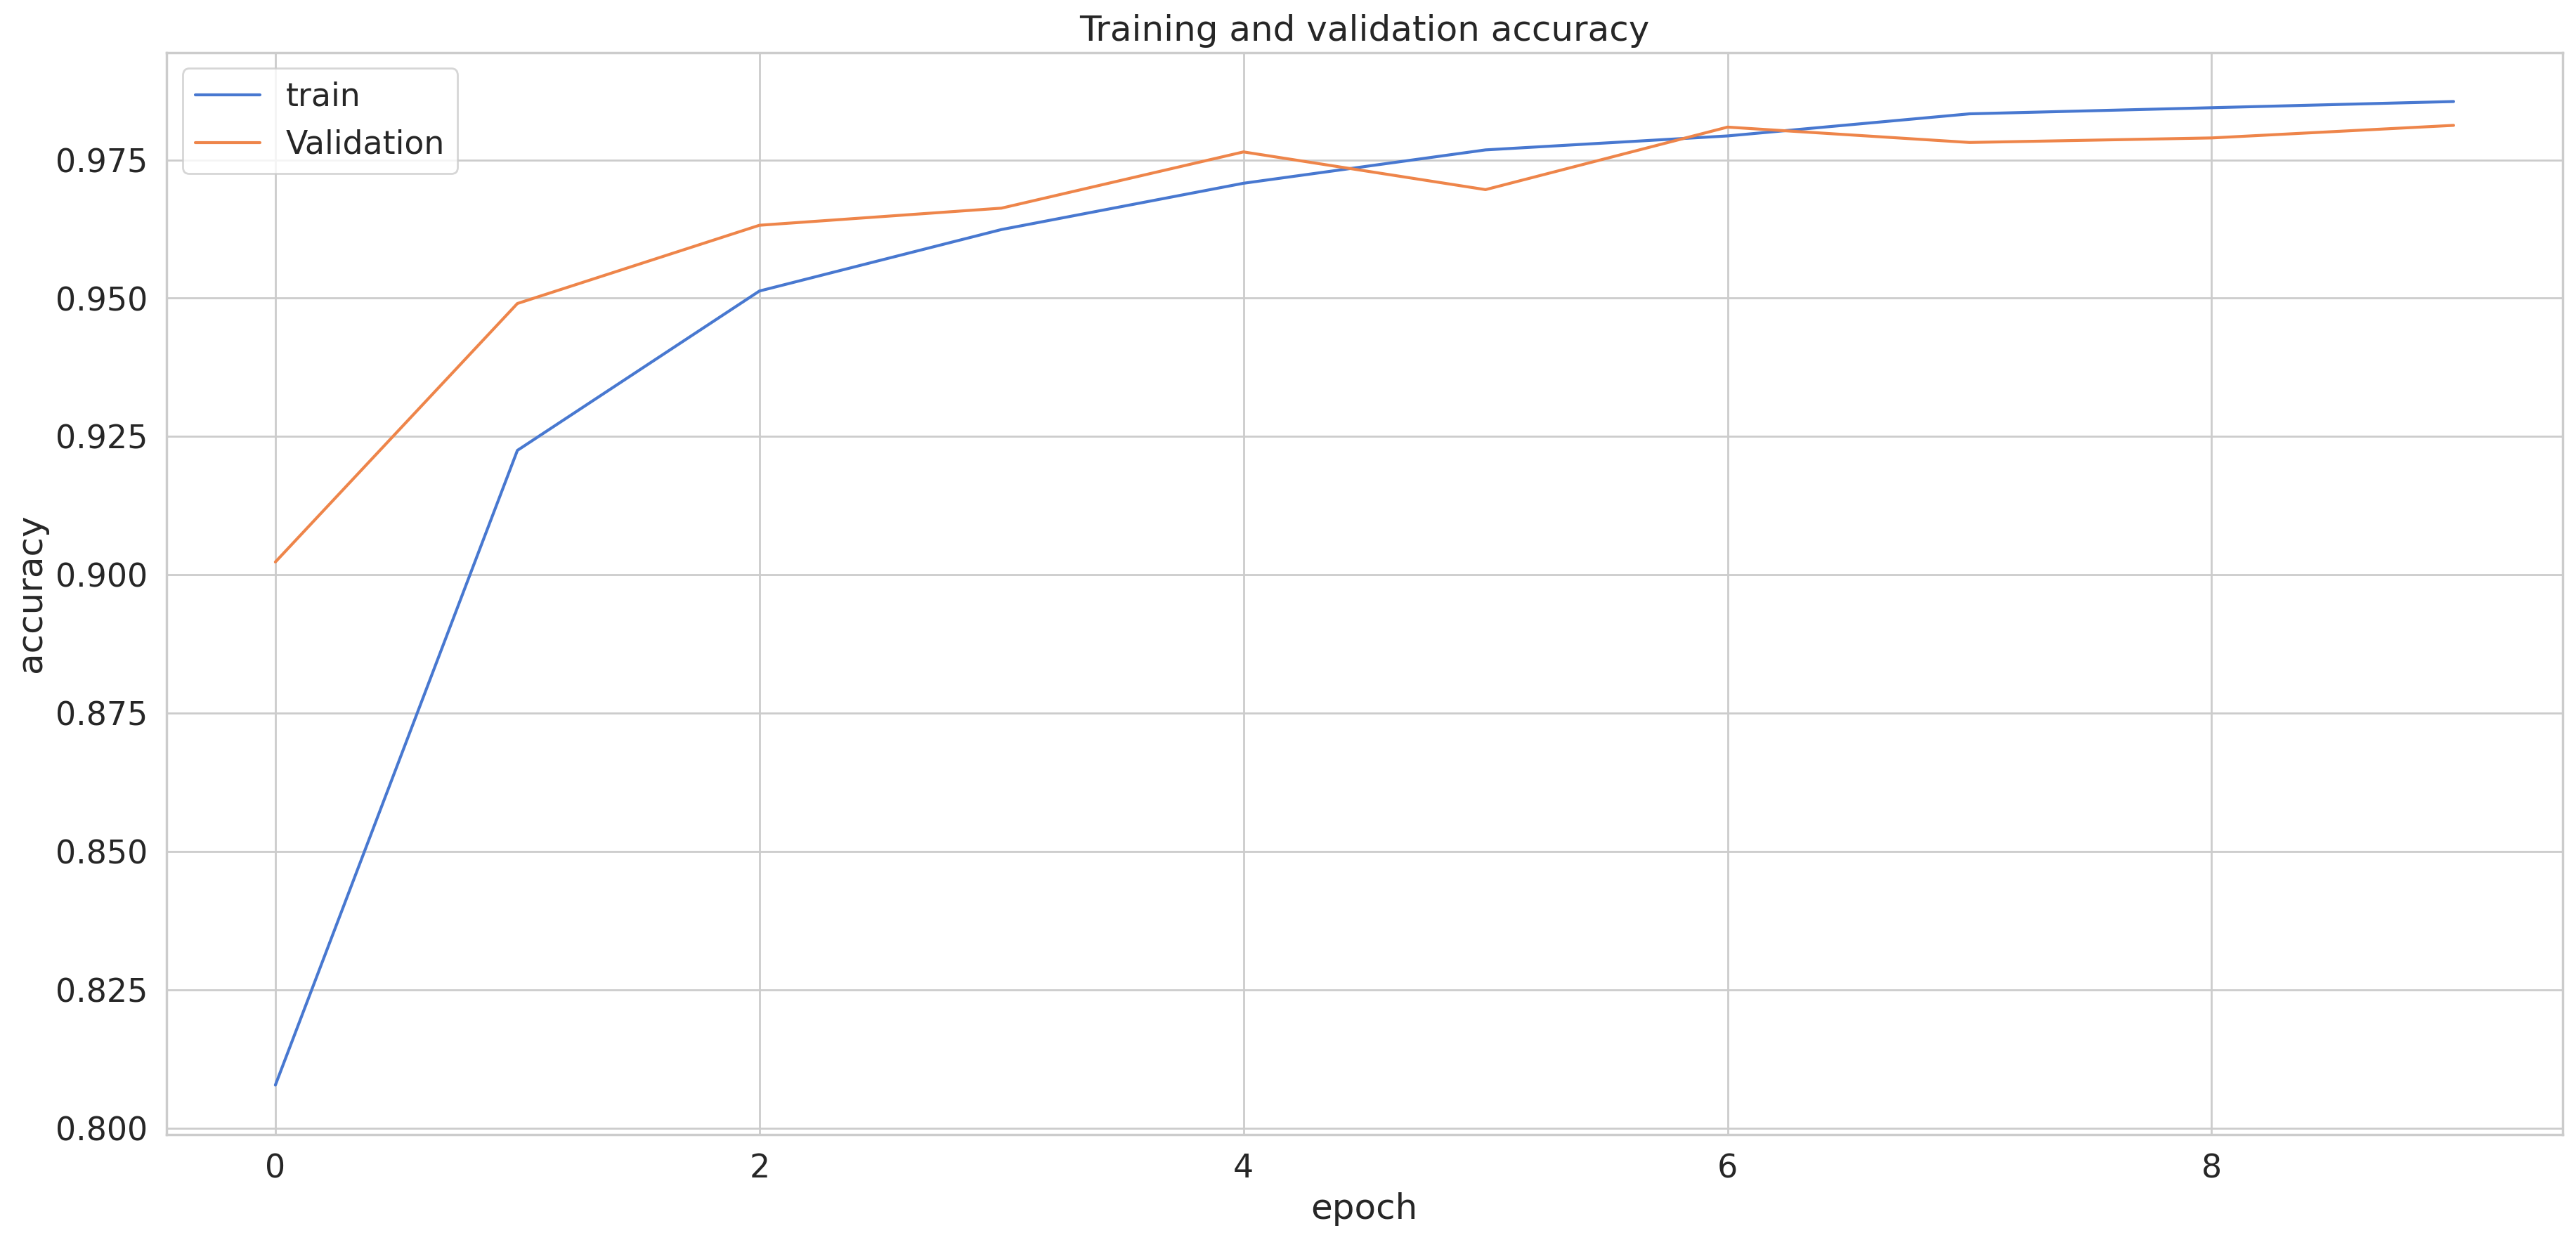

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

619/619 [==============================] - 105s 167ms/step
f1_score =  0.9826018875076719
0.9826236298429055
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8490
           1       0.99      0.99      0.99      6843
           2       0.97      0.93      0.95      2459
           3       0.94      0.97      0.95      2005

    accuracy                           0.98     19797
   macro avg       0.97      0.97      0.97     19797
weighted avg       0.98      0.98      0.98     19797



<Axes: >

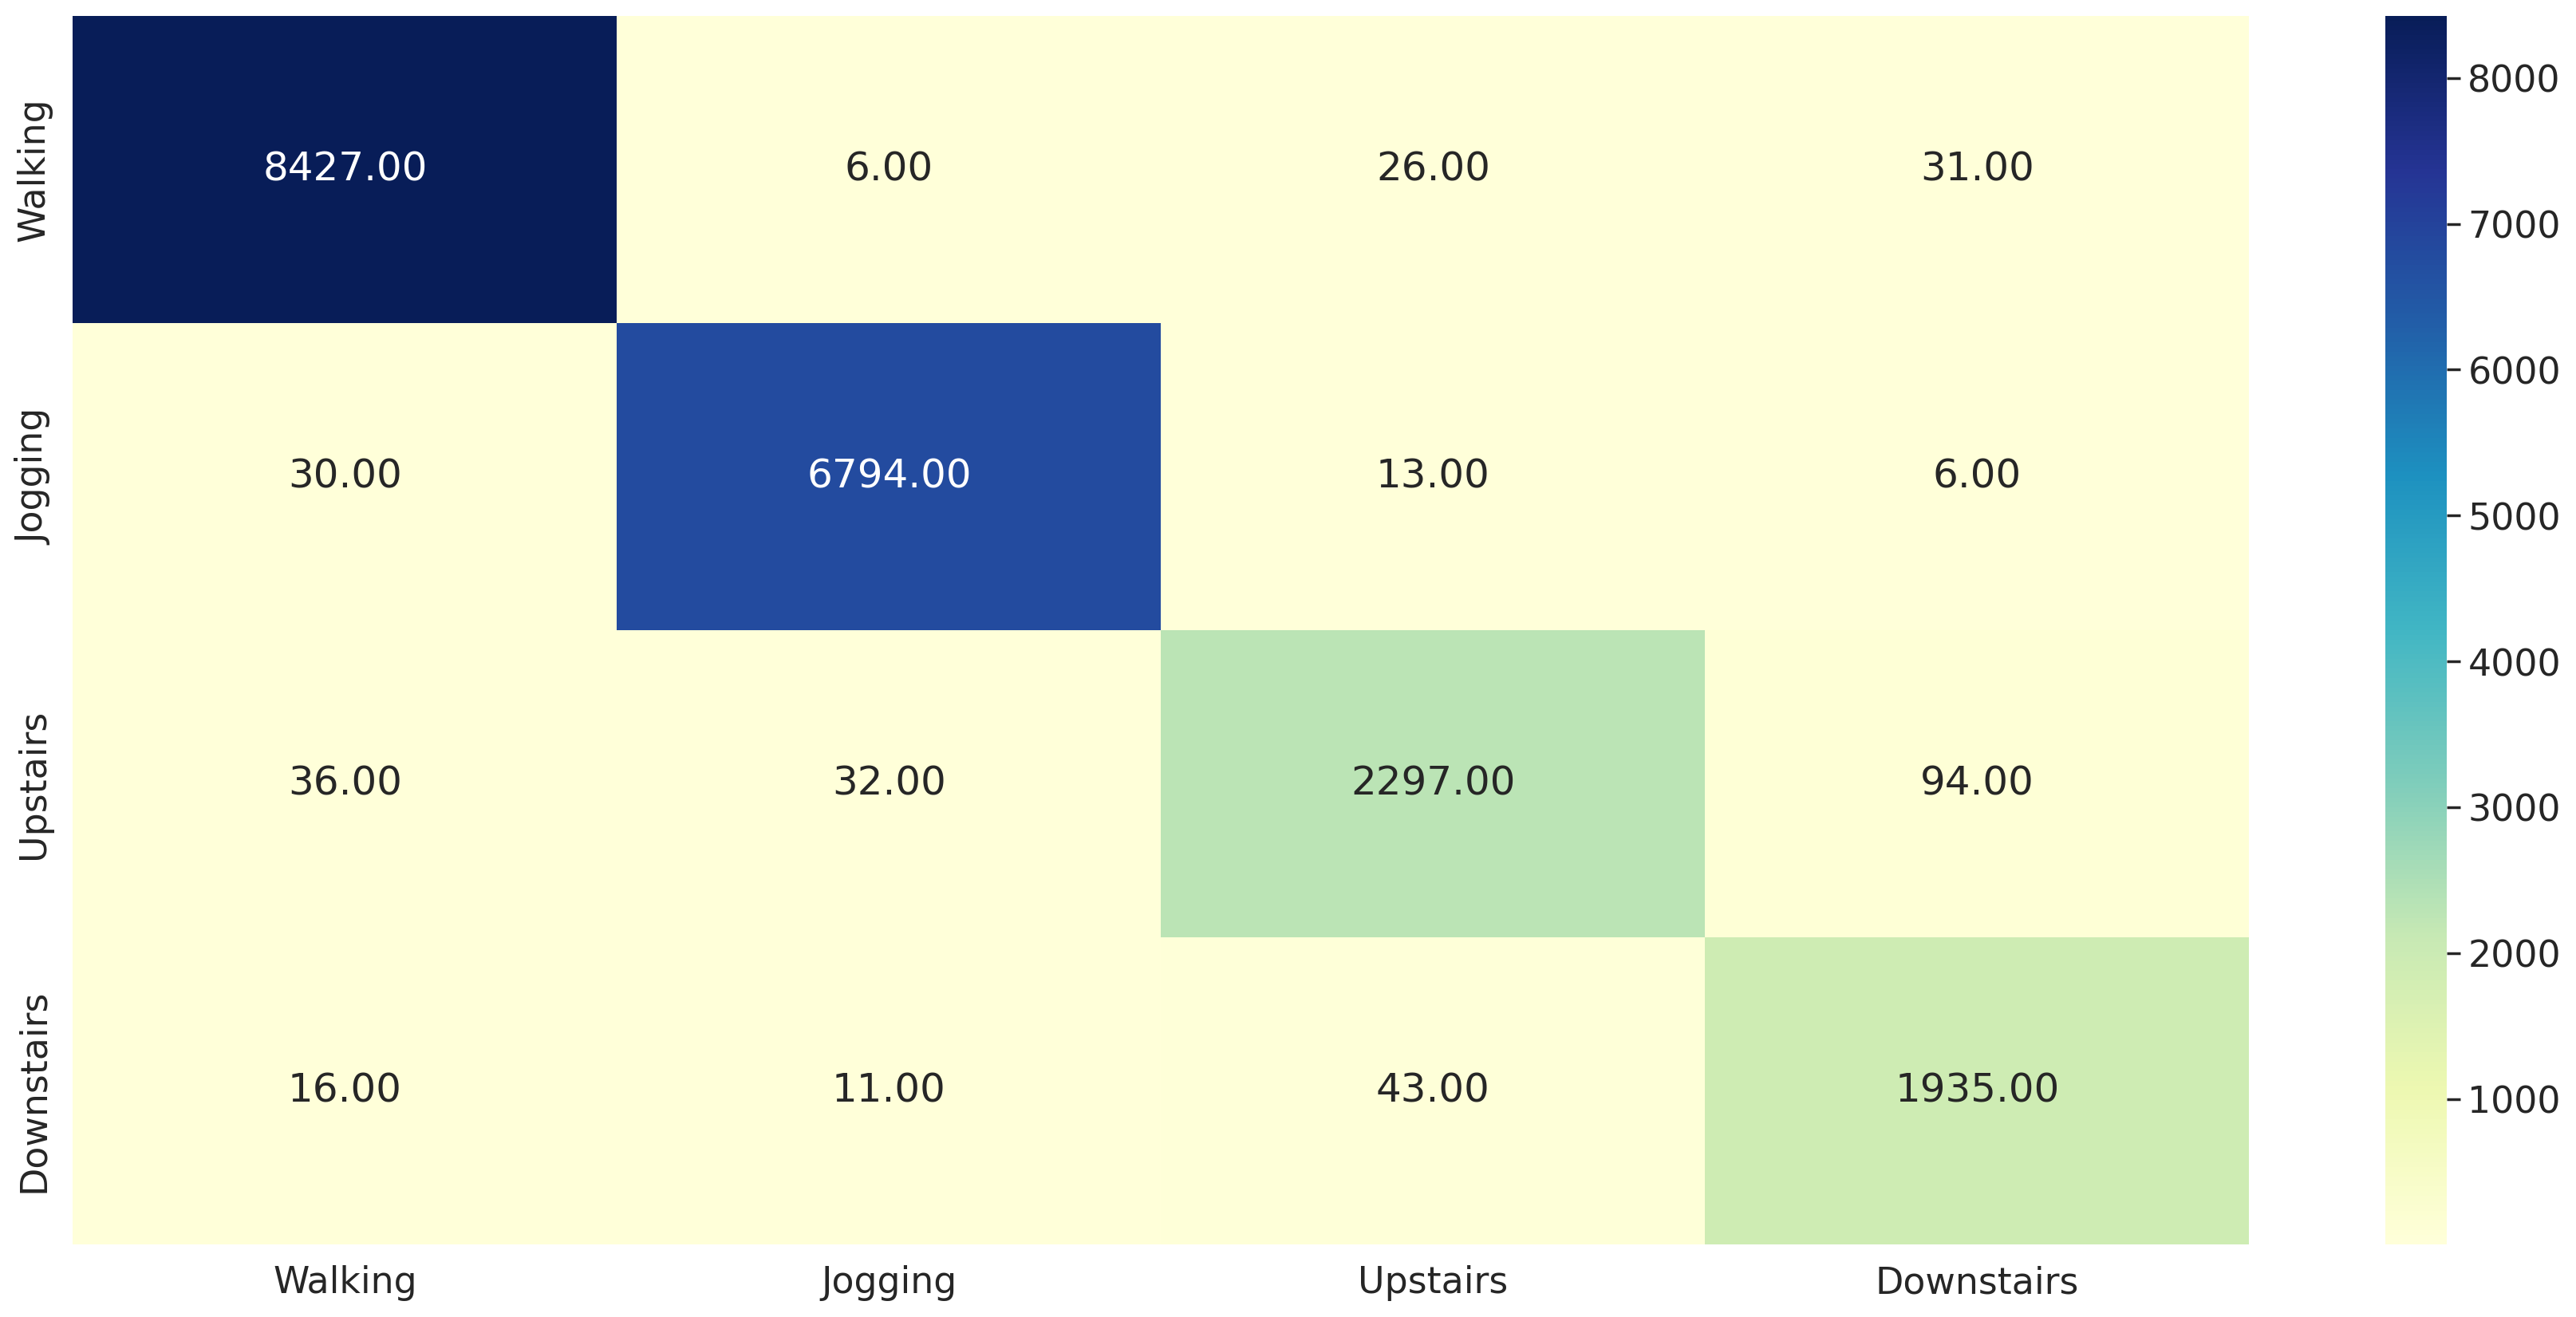

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM4

In [15]:
model = Sequential()
# RNN layer
model.add(Bidirectional(LSTM(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2]))))
# Dropout layer
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 50, 256)           135168    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 50, 256)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 50, 256)           394240    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 50, 256)           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 50, 256)           394240    
 onal)                                                           
                                                        

In [16]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
495/495 [==============================] - 938s 2s/step - loss: 0.5125 - accuracy: 0.8139 - val_loss: 0.3203 - val_accuracy: 0.8861
Epoch 2/10
495/495 [==============================] - 903s 2s/step - loss: 0.2303 - accuracy: 0.9196 - val_loss: 0.1540 - val_accuracy: 0.9489
Epoch 3/10
495/495 [==============================] - 915s 2s/step - loss: 0.1498 - accuracy: 0.9498 - val_loss: 0.1176 - val_accuracy: 0.9607
Epoch 4/10
495/495 [==============================] - 914s 2s/step - loss: 0.1169 - accuracy: 0.9608 - val_loss: 0.0862 - val_accuracy: 0.9702
Epoch 5/10
495/495 [==============================] - 913s 2s/step - loss: 0.0915 - accuracy: 0.9696 - val_loss: 0.0860 - val_accuracy: 0.9711
Epoch 6/10
495/495 [==============================] - 916s 2s/step - loss: 0.0748 - accuracy: 0.9756 - val_loss: 0.0609 - val_accuracy: 0.9794
Epoch 7/10
495/495 [==============================] - 914s 2s/step - loss: 0.0677 - accuracy: 0.9783 - val_loss: 0.0657 - val_accuracy: 0.9768

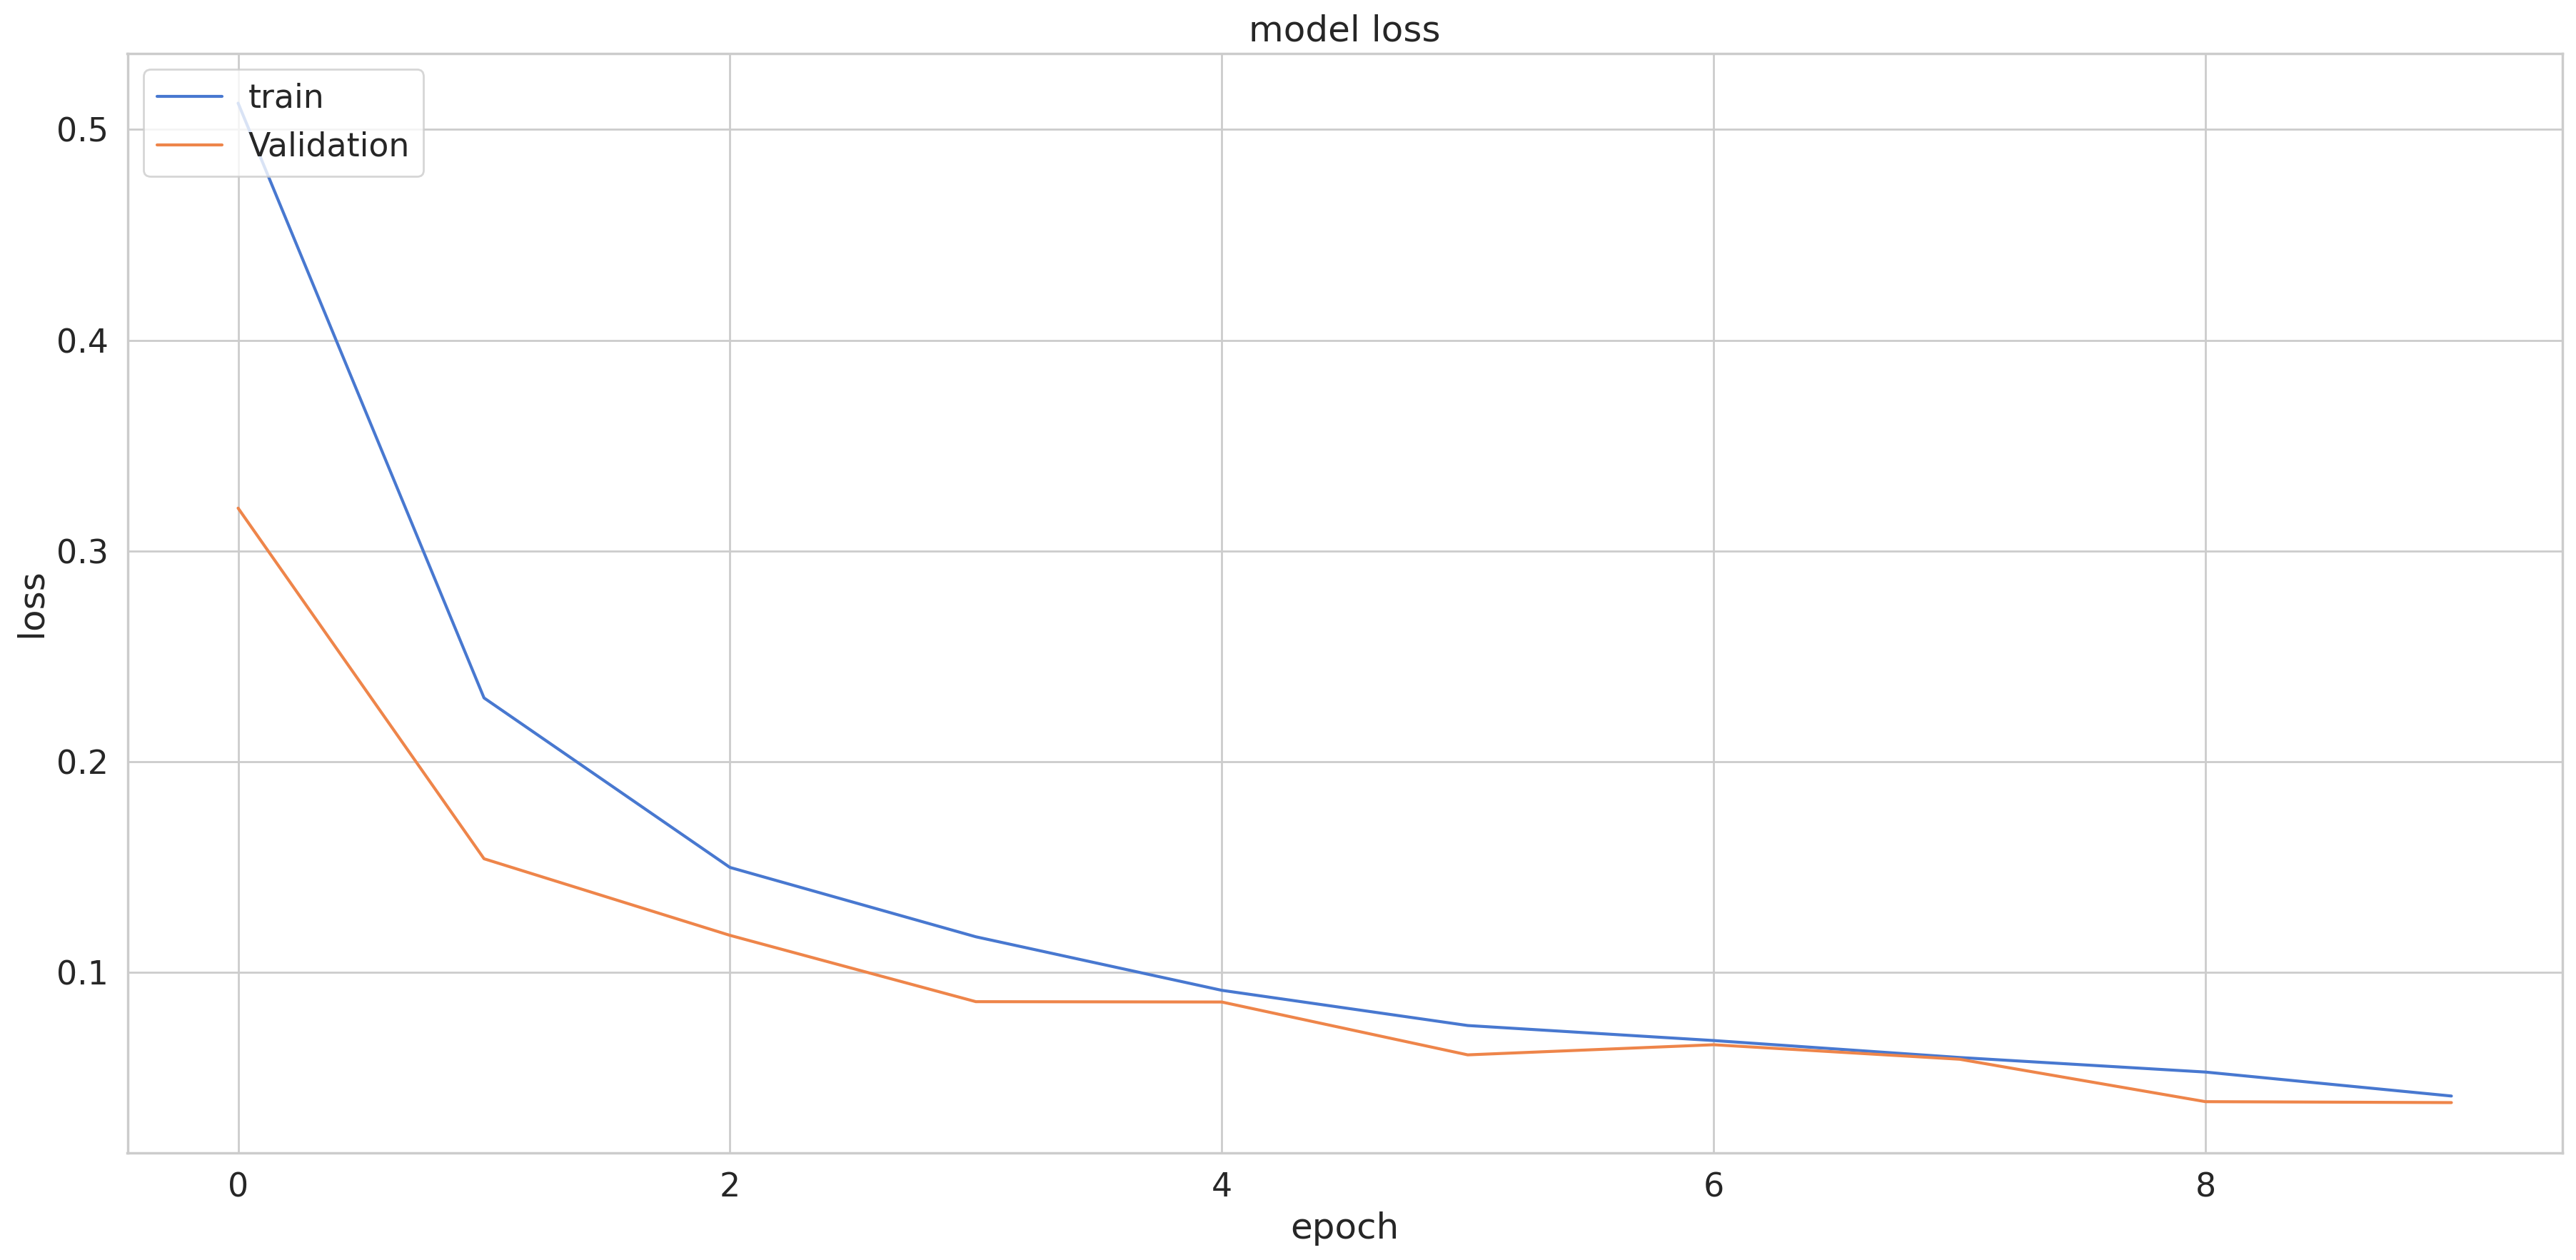

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

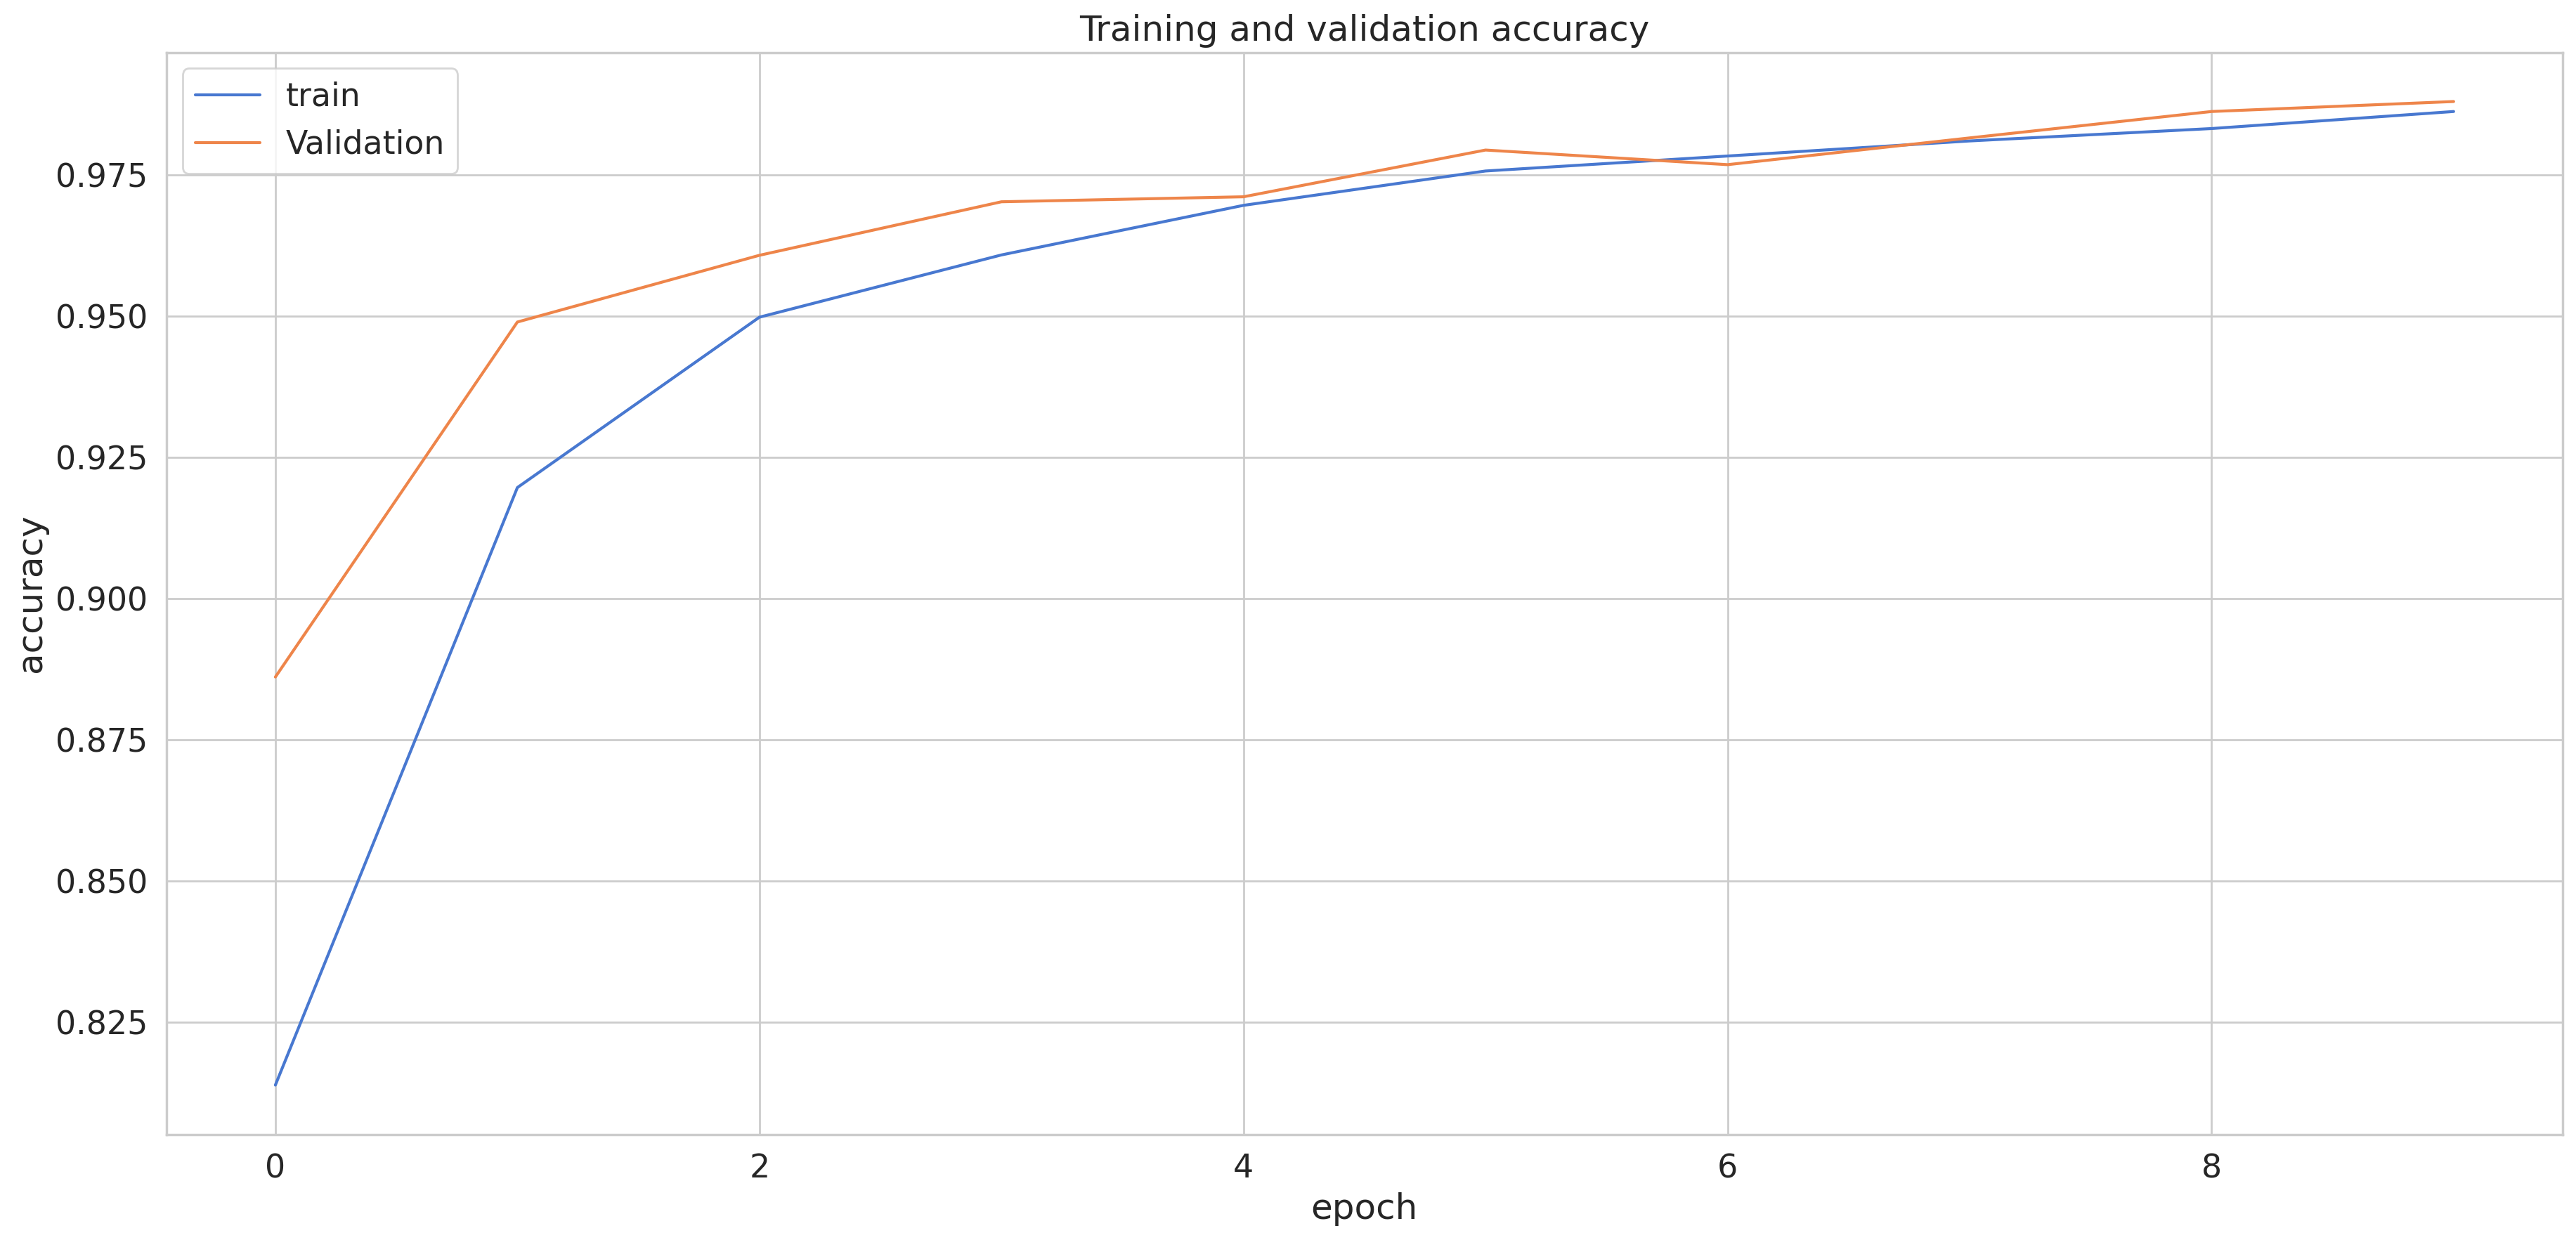

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

619/619 [==============================] - 151s 237ms/step
f1_score =  0.985459164682319
0.9854018285598828
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8490
           1       1.00      0.99      0.99      6843
           2       0.94      0.97      0.96      2459
           3       0.96      0.96      0.96      2005

    accuracy                           0.99     19797
   macro avg       0.97      0.98      0.98     19797
weighted avg       0.99      0.99      0.99     19797



<Axes: >

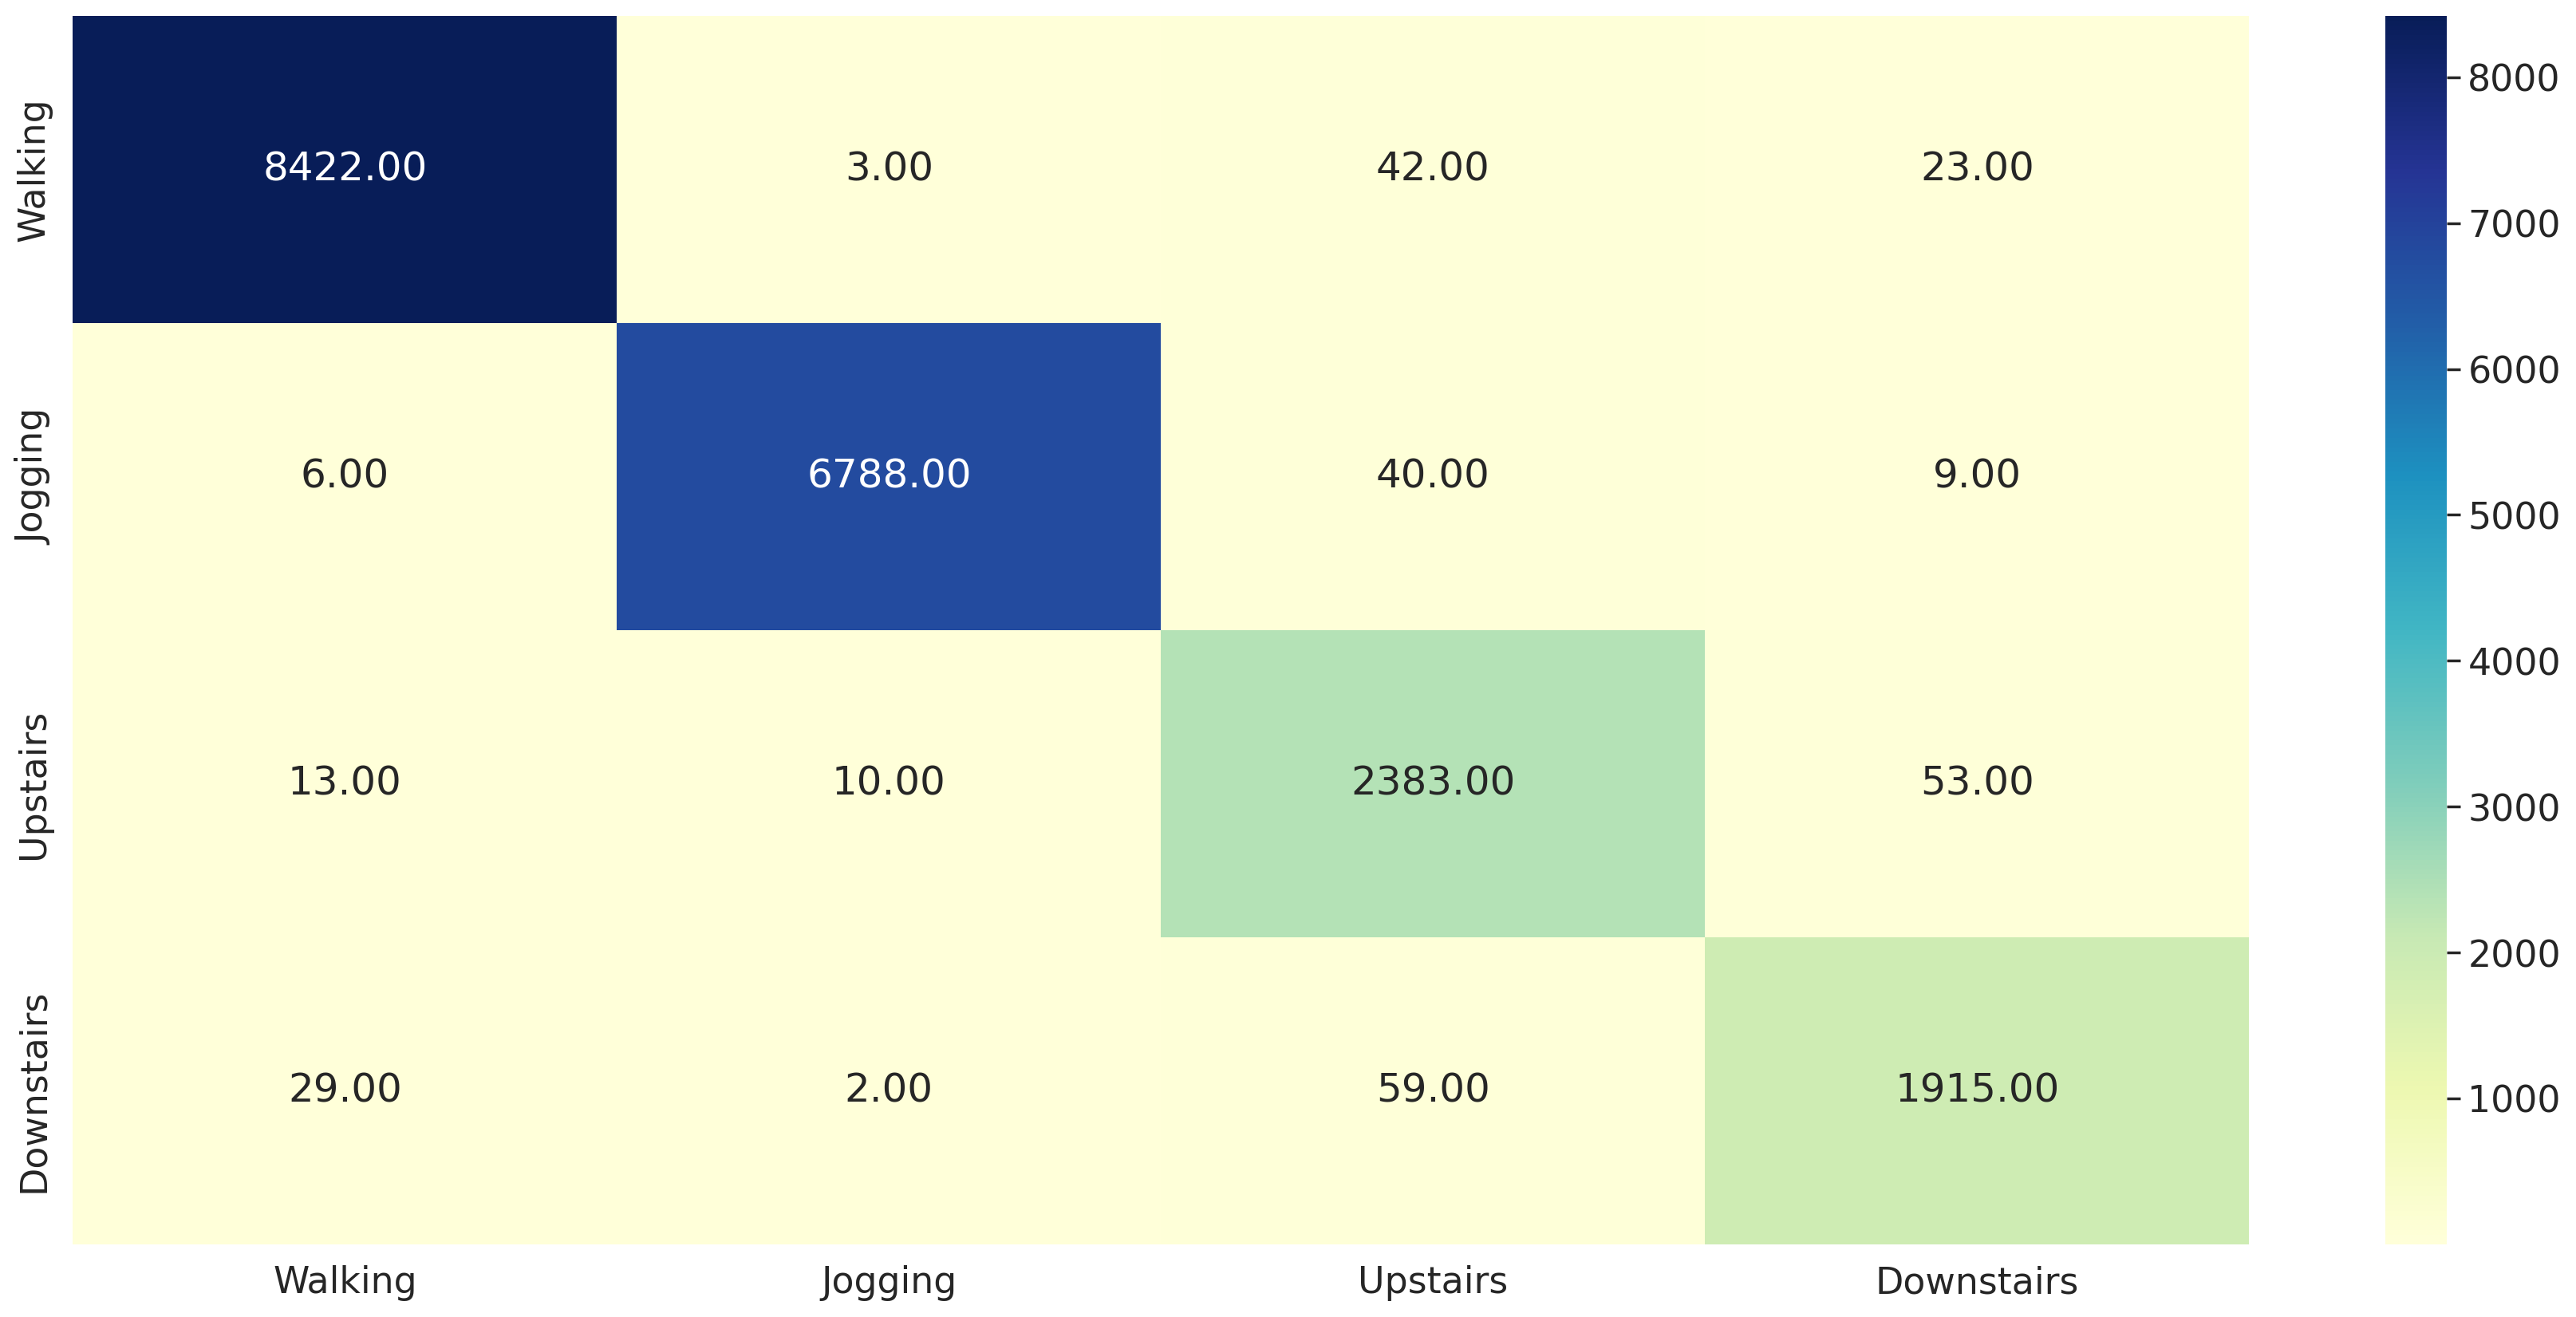

In [19]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM5

In [20]:
model = Sequential()
# RNN layer
model.add(Bidirectional(LSTM(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2]))))
# Dropout layer
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Dropout(0.5))


model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

# Display model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirecti  (None, 50, 256)           135168    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 50, 256)           0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 50, 256)           394240    
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 50, 256)           0         
                                                                 
 bidirectional_6 (Bidirecti  (None, 50, 256)           394240    
 onal)                                                           
                                                      

In [21]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
495/495 [==============================] - 1265s 3s/step - loss: 0.5695 - accuracy: 0.8003 - val_loss: 0.3072 - val_accuracy: 0.8954
Epoch 2/10
495/495 [==============================] - 1228s 2s/step - loss: 0.2620 - accuracy: 0.9108 - val_loss: 0.1962 - val_accuracy: 0.9356
Epoch 3/10
495/495 [==============================] - 1237s 3s/step - loss: 0.1679 - accuracy: 0.9455 - val_loss: 0.1353 - val_accuracy: 0.9573
Epoch 4/10
495/495 [==============================] - 1251s 3s/step - loss: 0.1243 - accuracy: 0.9607 - val_loss: 0.0857 - val_accuracy: 0.9715
Epoch 5/10
495/495 [==============================] - 1235s 2s/step - loss: 0.0985 - accuracy: 0.9680 - val_loss: 0.0824 - val_accuracy: 0.9734
Epoch 6/10
495/495 [==============================] - 1226s 2s/step - loss: 0.0795 - accuracy: 0.9760 - val_loss: 0.0864 - val_accuracy: 0.9738
Epoch 7/10
495/495 [==============================] - 1226s 2s/step - loss: 0.0680 - accuracy: 0.9786 - val_loss: 0.0737 - val_accuracy:

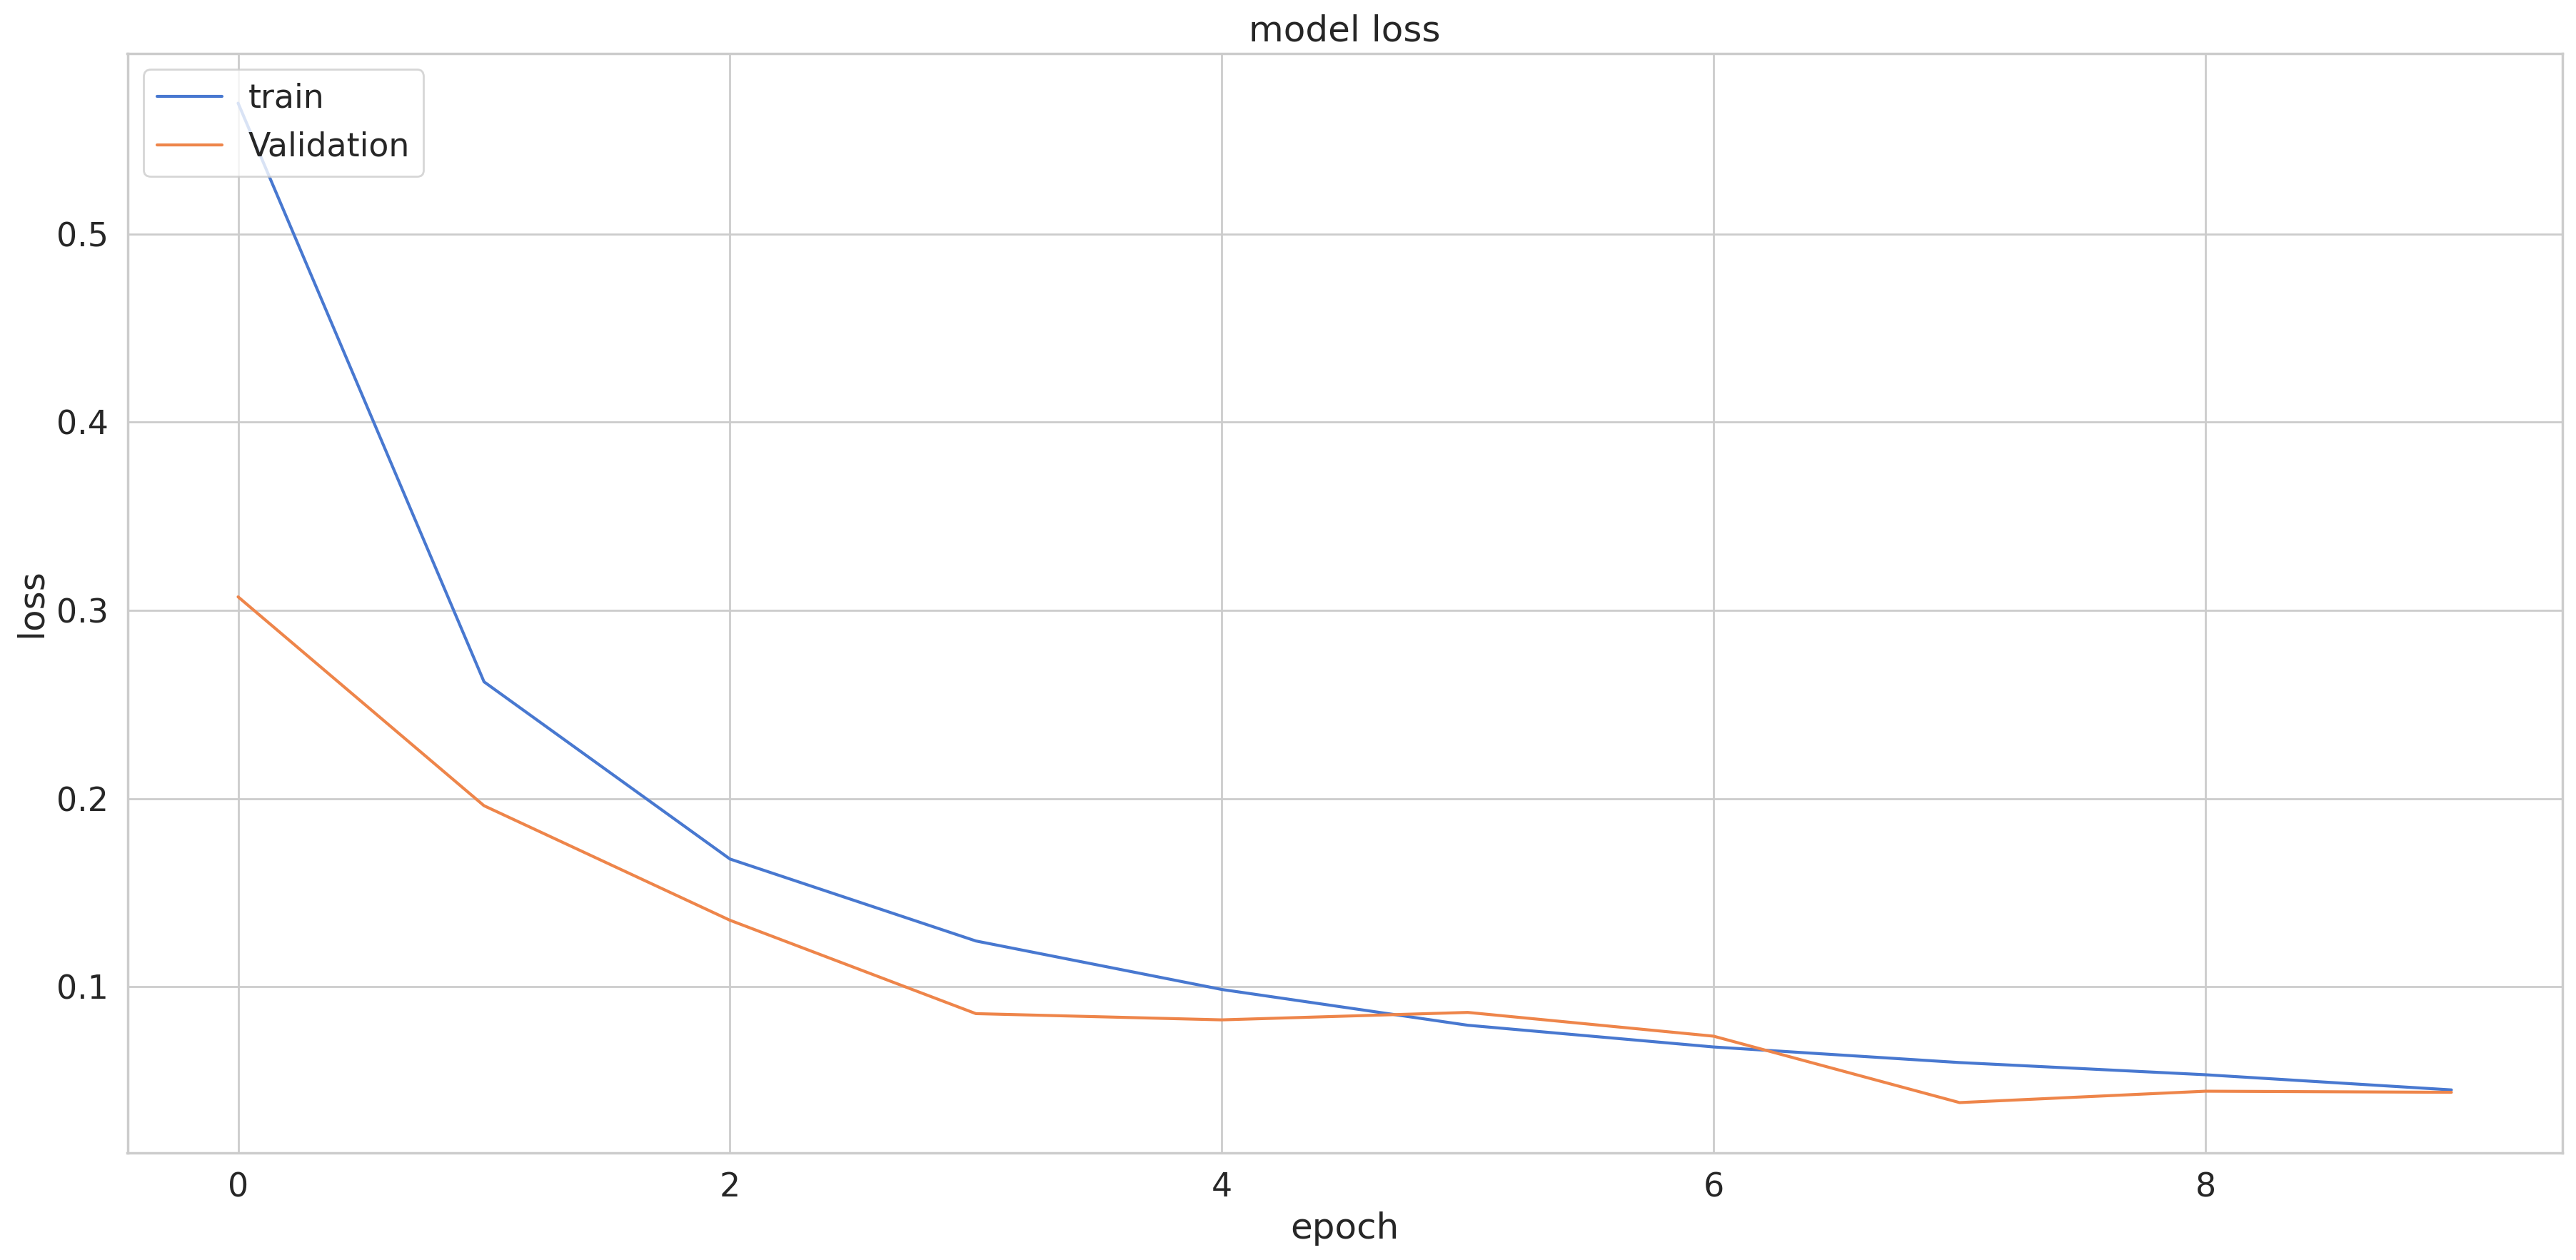

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

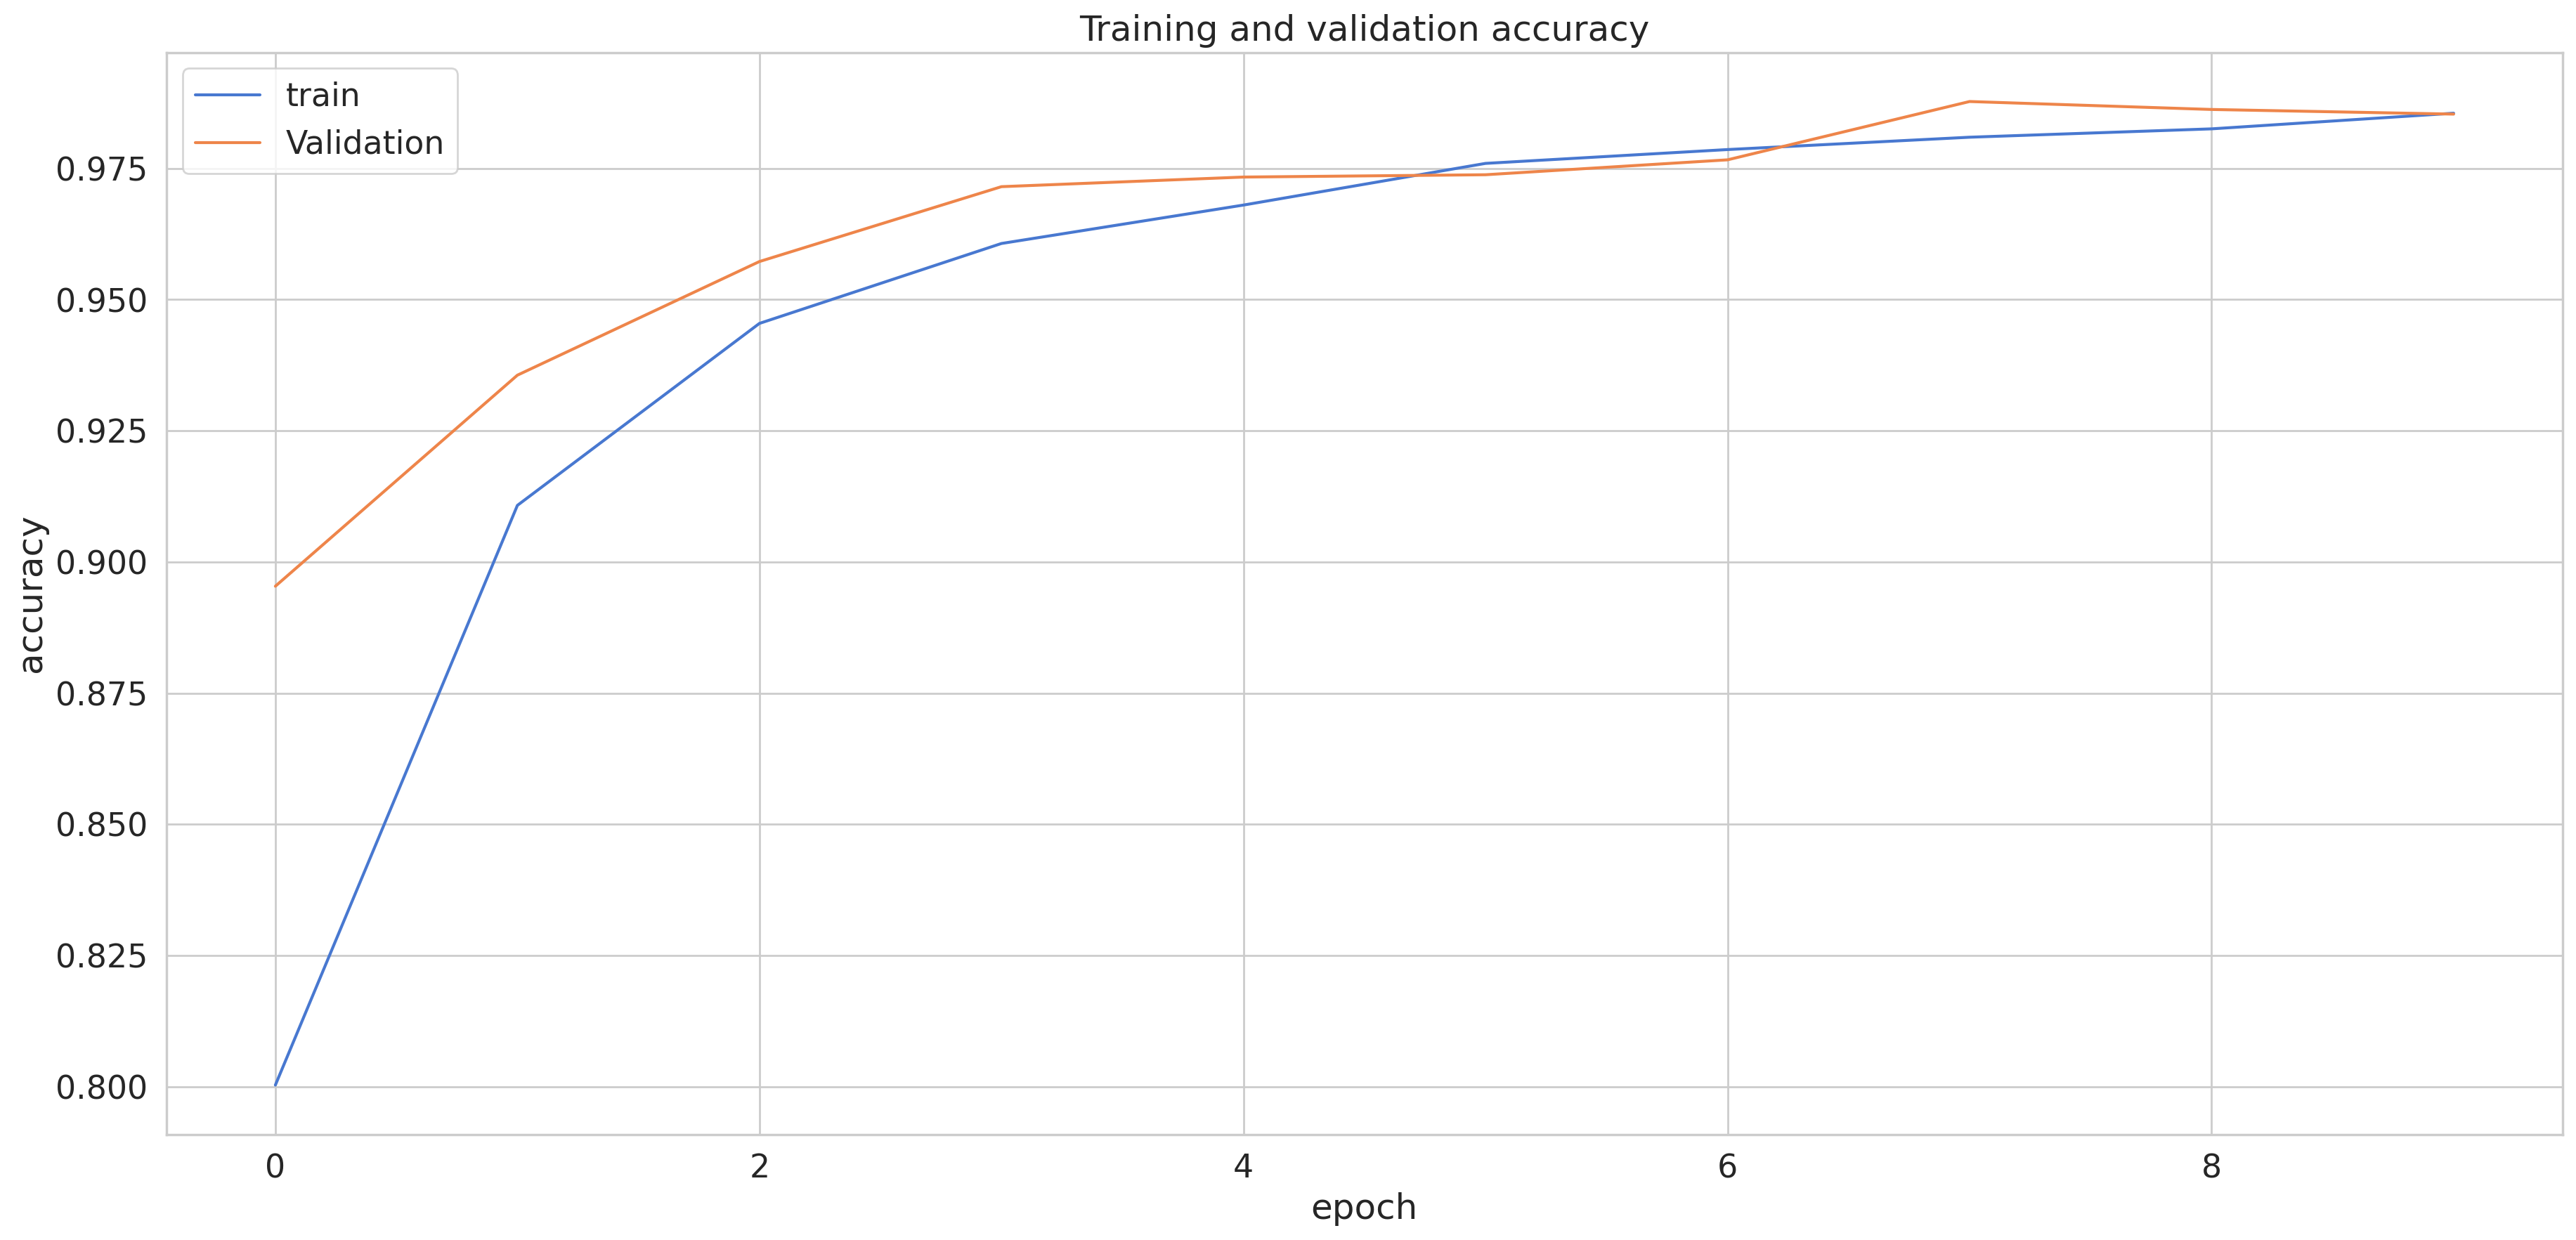

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

619/619 [==============================] - 185s 290ms/step
f1_score =  0.9852421374617589
0.9853008031519928
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8490
           1       1.00      1.00      1.00      6843
           2       0.96      0.97      0.96      2459
           3       0.97      0.93      0.95      2005

    accuracy                           0.99     19797
   macro avg       0.98      0.97      0.98     19797
weighted avg       0.99      0.99      0.99     19797



<Axes: >

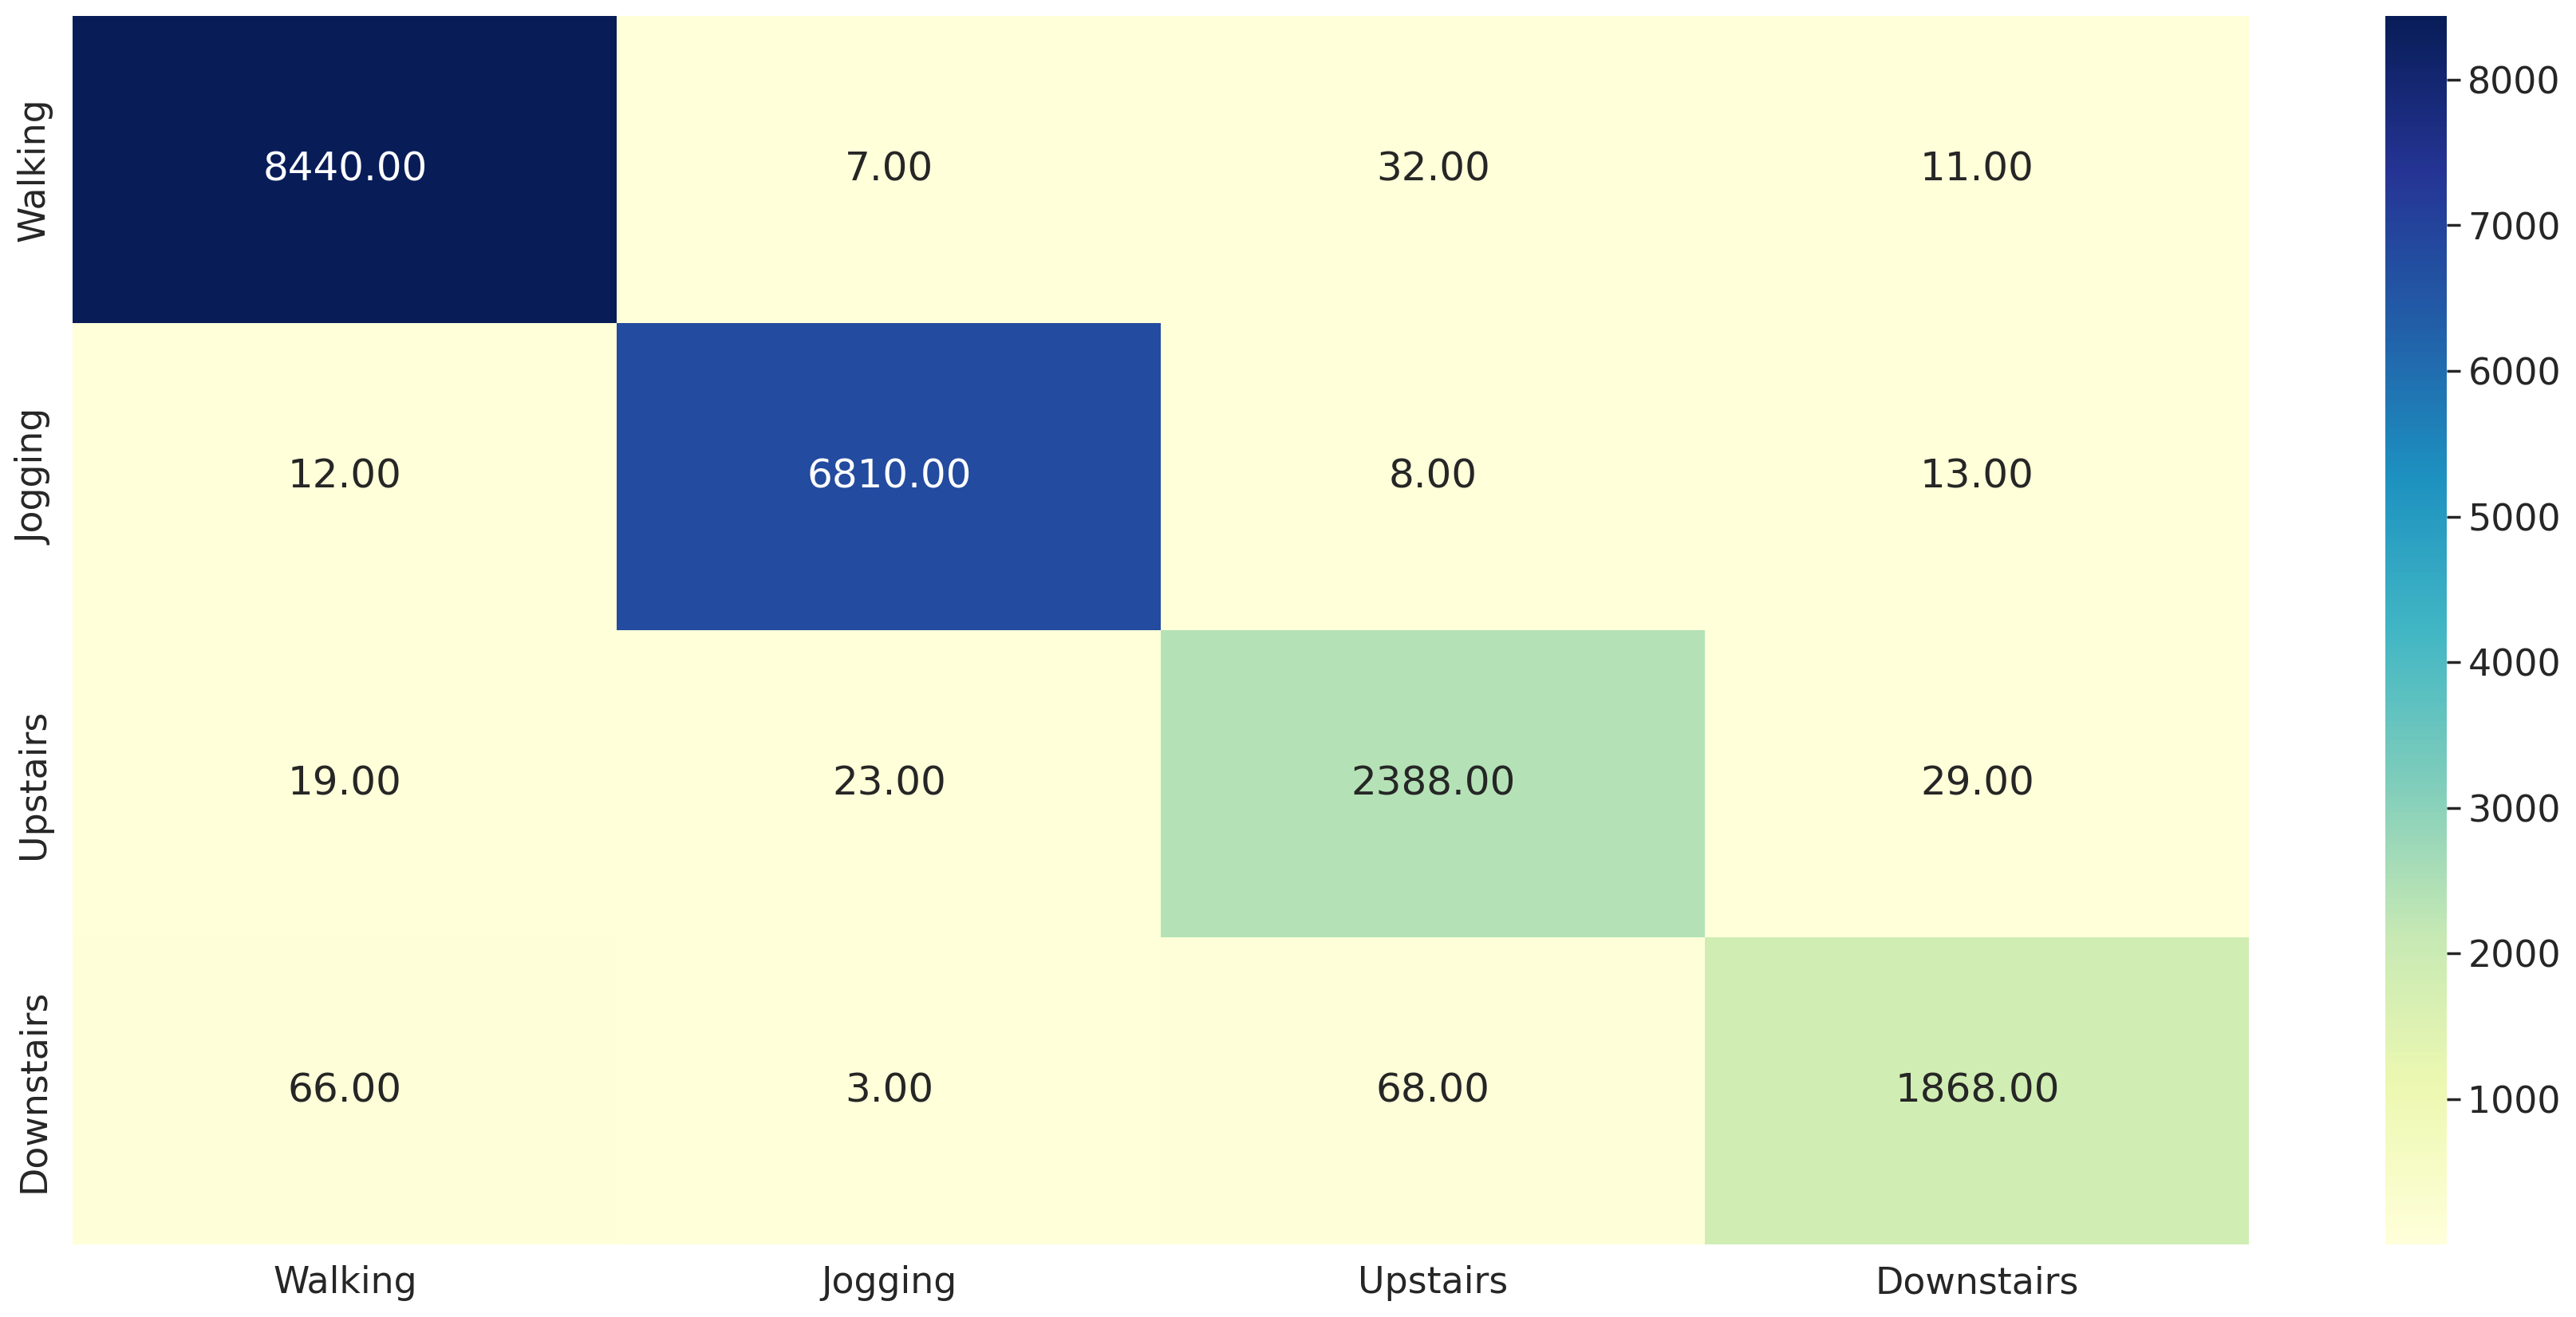

In [24]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')